# Part 1 

Dispel online property “hype” (TikTok/Instagram property agents, influencers) misrepresent affordability on Singapore housing (advising people to take max loans since interests paid will always be lower than the appreciation) Show actual videos during presentation & debunk hype with data.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [66]:
# Set pandas display options to show wider output
# https://data.gov.sg/collections/189/view -- for resale prices
# https://eservices.mas.gov.sg/statistics/dir/DomesticInterestRates.aspx -- for domestic interest rates (SORA)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load Domestic Interest Rates - read the SORA section from line 5167 to 10323
# Skip to line 5166 to get the header at line 5167
# Line 10323 is ",,22,-,-,-,-,-" so we read until line 10323
# nrows = 10323 - 5167 + 1 = 5157 rows (including header)
interest_rates_df = pd.read_csv('data/sora.csv', skiprows=5166, nrows=5157)

# The file has multiple headers repeated, so we need to filter out duplicate header rows
# Remove rows where the first column contains 'SORA Value Date' (these are repeated headers)
interest_rates_df = interest_rates_df[interest_rates_df.iloc[:, 0] != 'SORA Value Date']

# Remove any rows where Day column is '-' or NaN (these are separator/footer rows)
interest_rates_df = interest_rates_df[interest_rates_df.iloc[:, 2] != '-']
interest_rates_df = interest_rates_df.dropna(subset=[interest_rates_df.columns[2]])

# Clean up the column names
interest_rates_df.columns = ['Year', 'Month', 'Day', 'Publication Date', 'SORA', 
                              'Compound SORA - 1 month', 'Compound SORA - 3 month', 
                              'Compound SORA - 6 month']

# Forward fill Year and Month to populate the NaN values
interest_rates_df['Year'] = interest_rates_df['Year'].ffill()
interest_rates_df['Month'] = interest_rates_df['Month'].ffill()

# Reset index after filtering
interest_rates_df = interest_rates_df.reset_index(drop=True)

# Drop the last row (which is the separator line)
interest_rates_df = interest_rates_df.iloc[:-1]

print("Domestic Interest Rates (SORA Data) loaded:")
print(f"Shape: {interest_rates_df.shape}")
print(f"Columns: {list(interest_rates_df.columns)}")
print("\nFirst few rows:")
print(interest_rates_df.head(15))
print("\nLast few rows:")
print(interest_rates_df.tail(15))
print("\nData types:")
print(interest_rates_df.dtypes)
print("\n" + "="*80 + "\n")

Domestic Interest Rates (SORA Data) loaded:
Shape: (5096, 8)
Columns: ['Year', 'Month', 'Day', 'Publication Date', 'SORA', 'Compound SORA - 1 month', 'Compound SORA - 3 month', 'Compound SORA - 6 month']

First few rows:
    Year Month   Day Publication Date    SORA Compound SORA - 1 month Compound SORA - 3 month Compound SORA - 6 month
0   2005   Jul   1.0      04 Jul 2005  1.7998                       -                       -                       -
1   2005   Jul   4.0      05 Jul 2005  1.7480                       -                       -                       -
2   2005   Jul   5.0      06 Jul 2005  1.7686                       -                       -                       -
3   2005   Jul   6.0      07 Jul 2005  1.7971                       -                       -                       -
4   2005   Jul   7.0      08 Jul 2005  1.7956                       -                       -                       -
5   2005   Jul   8.0      11 Jul 2005  1.7851                       -  

In [67]:
# Load all Resale Flat Prices files
resale_files = [
    'data/ResaleFlatPrices/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv',
    'data/ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv',
    'data/ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv',
    'data/ResaleFlatPrices/Resale flat prices based on registration date from Jan-2017 onwards.csv'
]

# Load and concatenate all resale price files
resale_dfs = []
for file in resale_files:
    df = pd.read_csv(file)
    print(f"Loaded: {file}")
    print(f"  Shape: {df.shape}")
    resale_dfs.append(df)

# Combine all resale flat prices into one dataframe
resale_flat_prices_df = pd.concat(resale_dfs, ignore_index=True)

print("\n" + "="*80)
print("\nCombined Resale Flat Prices loaded:")
print(f"Total Shape: {resale_flat_prices_df.shape}")
print(f"Columns: {list(resale_flat_prices_df.columns)}")
print(f"Date Range: {resale_flat_prices_df.iloc[0, 0] if len(resale_flat_prices_df) > 0 else 'N/A'} to {resale_flat_prices_df.iloc[-1, 0] if len(resale_flat_prices_df) > 0 else 'N/A'}")
print("\nFirst few rows:")
print(resale_flat_prices_df.head())
print("\nLast few rows:")
print(resale_flat_prices_df.tail())
print("\nData types:")
print(resale_flat_prices_df.dtypes)

Loaded: data/ResaleFlatPrices/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv
  Shape: (369651, 10)
Loaded: data/ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv
  Shape: (52203, 10)
Loaded: data/ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv
  Shape: (37153, 11)
Loaded: data/ResaleFlatPrices/Resale flat prices based on registration date from Jan-2017 onwards.csv
  Shape: (217894, 11)


Combined Resale Flat Prices loaded:
Total Shape: (676901, 11)
Columns: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease']
Date Range: 2000-01 to 2025-07

First few rows:
     month        town flat_type block       street_name storey_range  floor_area_sqm      flat_model  lease_commence_date  resale_price remaining_lease
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 

## Data Normalization Strategies

To compare HDB resale prices with SORA interest rates fairly, we need to account for:
- **Location bias** (prime vs non-prime areas)
- **Size differences** (2-room vs 5-room)
- **Storey level** (low vs high floor)
- **Age of flat**

## Strategic Segmentation for Analysis

Instead of creating so many plots (one per town, storey and age), we'll use strategic grouping to make the analysis clearer and more impactful.

### Approach:
1. **Group towns by maturity/price tier** (Mature vs Non-Mature)
2. **Create storey range categories** (Low/Mid/High floors)
3. **Calculate age range categories** (Unknown, Young, Middle-aged, Old)
4. **Plot growth for each segment**
5. **Compare against SORA rates**

This will show whether the "max loan = max profit" myth holds across different property segments.

In [68]:
# Check unique towns first
print("Unique Towns in Dataset:")
print(resale_flat_prices_df['town'].unique())
print(f"\nTotal unique towns: {resale_flat_prices_df['town'].nunique()}")

# Calculate price per sqm and date
resale_flat_prices_df['price_per_sqm'] = resale_flat_prices_df['resale_price'] / resale_flat_prices_df['floor_area_sqm']
resale_flat_prices_df['date'] = pd.to_datetime(resale_flat_prices_df['month'])

# STRATEGIC GROUPING: Categorize towns by maturity
mature_towns = ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 
                'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']

non_mature_towns = ['ANG MO KIO', 'BEDOK', 'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG',
                    'JURONG EAST', 'JURONG WEST', 'PASIR RIS', 'PUNGGOL', 'SEMBAWANG',
                    'SENGKANG', 'SERANGOON', 'TAMPINES', 'WOODLANDS', 'YISHUN']

resale_flat_prices_df['town_category'] = resale_flat_prices_df['town'].apply(
    lambda x: 'Mature' if x in mature_towns else 'Non-Mature'
)

# STOREY CATEGORIZATION
def extract_floor_level(storey_range):
    if pd.isna(storey_range):
        return None
    # Get the first number from the range
    first_num = storey_range.split(' TO ')[0]
    return int(first_num)

resale_flat_prices_df['floor_level'] = resale_flat_prices_df['storey_range'].apply(extract_floor_level)

# Create floor categories
def categorize_floor(floor_level):
    if pd.isna(floor_level):
        return 'Unknown'
    elif floor_level <= 5:
        return 'Low (01-05)'
    elif floor_level <= 12:
        return 'Mid (06-12)'
    else:
        return 'High (13+)'

resale_flat_prices_df['floor_category'] = resale_flat_prices_df['floor_level'].apply(categorize_floor)

# AGE CATEGORIZATION - REDUCED TO 3 CATEGORIES
if 'lease_commence_date' in resale_flat_prices_df.columns:
    resale_flat_prices_df['transaction_year'] = resale_flat_prices_df['date'].dt.year
    resale_flat_prices_df['flat_age'] = resale_flat_prices_df['transaction_year'] - resale_flat_prices_df['lease_commence_date']
    resale_flat_prices_df['remaining_lease_years'] = 99 - resale_flat_prices_df['flat_age']
    
    def categorize_age(remaining_lease):
        if pd.isna(remaining_lease):
            return 'Unknown'
        elif remaining_lease >= 60:
            return 'New/Young (60+ yrs)'
        elif remaining_lease >= 40:
            return 'Middle-aged (40-59 yrs)'
        else:
            return 'Old (<40 yrs)'
    
    resale_flat_prices_df['age_category'] = resale_flat_prices_df['remaining_lease_years'].apply(categorize_age)
else:
    resale_flat_prices_df['age_category'] = 'Unknown'

print("\n" + "="*80)
print("\nTown Categories:")
print(resale_flat_prices_df['town_category'].value_counts())

print("\nFloor Categories:")
print(resale_flat_prices_df['floor_category'].value_counts())

print("\nAge Categories:")
print(resale_flat_prices_df['age_category'].value_counts())

# Calculate median price per sqm for each segment (including age)
segment_analysis = resale_flat_prices_df.groupby(['date', 'town_category', 'floor_category', 'age_category']).agg({
    'price_per_sqm': 'median',
    'resale_price': 'median'
}).reset_index()

print("\n" + "="*80)
print("\nSegment Analysis Preview:")
print(segment_analysis.tail(20))

print("\n" + "="*80)
print("\nSegment Summary:")
summary = segment_analysis.groupby(['town_category', 'floor_category', 'age_category'])['price_per_sqm'].agg(['mean', 'median', 'min', 'max'])
print(summary)

Unique Towns in Dataset:
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'QUEENSTOWN' 'SENGKANG' 'SERANGOON' 'TAMPINES' 'TOA PAYOH'
 'WOODLANDS' 'YISHUN' 'SEMBAWANG' 'PUNGGOL']

Total unique towns: 26


Town Categories:
town_category
Non-Mature    546627
Mature        130274
Name: count, dtype: int64

Floor Categories:
floor_category
Low (01-05)    300205
Mid (06-12)    279520
High (13+)      97176
Name: count, dtype: int64

Age Categories:
age_category
New/Young (60+ yrs)        631339
Middle-aged (40-59 yrs)     45562
Name: count, dtype: int64


Town Categories:
town_category
Non-Mature    546627
Mature        130274
Name: count, dtype: int64

Floor Categories:
floor_category
Low (01-05)    300205
Mid (06-12)    279520
High (13+)      97176
Name: count, dtype: int64

Age Categories:
age_category
New/Young (

## Exploring SORA rates and the Trends

Checking date range in raw data:
First date string: 2005-Jul-1
Last date string: 2025-Oct-21
First parsed date: 2005-07-01 00:00:00
Last parsed date: 2025-10-21 00:00:00

After filtering NaN values: 5096 rows
Available year range: 2005 to 2025
After date filtering (2005-2025): 5096 rows


Checking date range in raw data:
First date string: 2005-Jul-1
Last date string: 2025-Oct-21
First parsed date: 2005-07-01 00:00:00
Last parsed date: 2025-10-21 00:00:00

After filtering NaN values: 5096 rows
Available year range: 2005 to 2025
After date filtering (2005-2025): 5096 rows


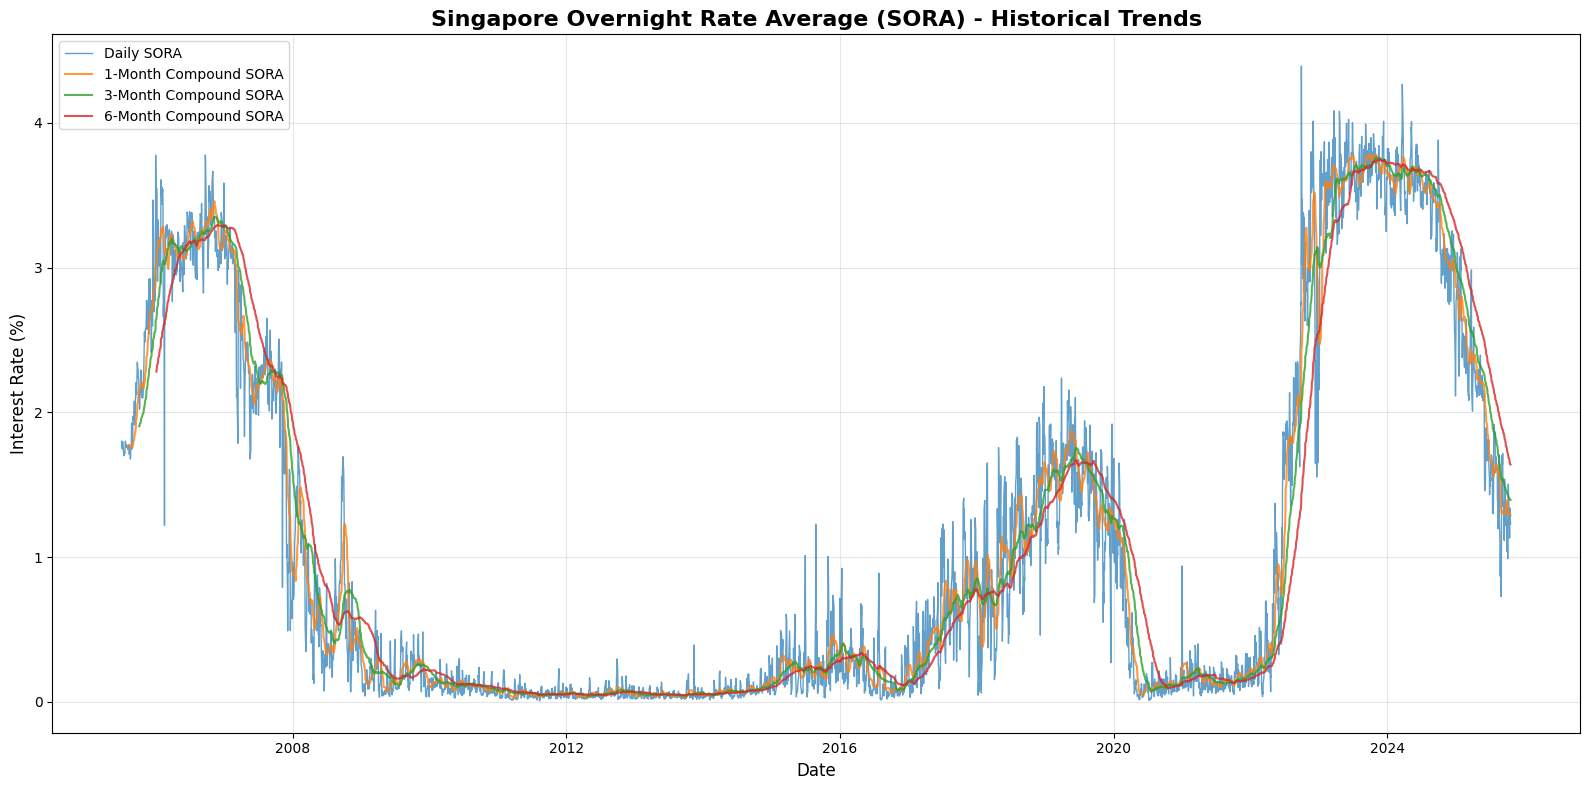


SORA Statistics:
Date Range: 2005-07-01 00:00:00 to 2025-10-21 00:00:00

Daily SORA:
  Min: 0.0054%
  Max: 4.3916%
  Mean: 1.0746%
  Current: 1.2262%


In [69]:
# Plot SORA Interest Rates Over Time
# First, prepare the interest rates data
# Convert Day to integer to remove decimals, then create date string
interest_rates_df['Day'] = pd.to_numeric(interest_rates_df['Day'], errors='coerce')
interest_rates_df['Day_int'] = interest_rates_df['Day'].fillna(1).astype(int)  # Use 1 as default if NaN
interest_rates_df['date_string'] = interest_rates_df['Year'].astype(str) + '-' + interest_rates_df['Month'].astype(str) + '-' + interest_rates_df['Day_int'].astype(str)
interest_rates_df['date'] = pd.to_datetime(interest_rates_df['date_string'], format='%Y-%b-%d', errors='coerce')

# Debug: Check what dates we actually have
print("Checking date range in raw data:")
print(f"First date string: {interest_rates_df['date_string'].iloc[0]}")
print(f"Last date string: {interest_rates_df['date_string'].iloc[-1]}")
print(f"First parsed date: {interest_rates_df['date'].iloc[0]}")
print(f"Last parsed date: {interest_rates_df['date'].iloc[-1]}")

interest_rates_df['SORA'] = pd.to_numeric(interest_rates_df['SORA'], errors='coerce')
interest_rates_df['Compound SORA - 1 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 1 month'], errors='coerce')
interest_rates_df['Compound SORA - 3 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 3 month'], errors='coerce')
interest_rates_df['Compound SORA - 6 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 6 month'], errors='coerce')

# Filter out rows with missing SORA values and invalid dates
interest_rates_plot = interest_rates_df.dropna(subset=['SORA', 'date'])

print(f"\nAfter filtering NaN values: {len(interest_rates_plot)} rows")

# Filter to show data from 2000 to 2025 (only if we have data)
if len(interest_rates_plot) > 0:
    min_year = interest_rates_plot['date'].dt.year.min()
    max_year = interest_rates_plot['date'].dt.year.max()
    print(f"Available year range: {min_year} to {max_year}")
    
    # Adjust filter based on available data
    start_year = max(2000, min_year) if not pd.isna(min_year) else min_year
    end_year = min(2025, max_year) if not pd.isna(max_year) else max_year
    
    interest_rates_plot = interest_rates_plot[
        (interest_rates_plot['date'].dt.year >= start_year) & 
        (interest_rates_plot['date'].dt.year <= end_year)
    ]
    print(f"After date filtering ({start_year}-{end_year}): {len(interest_rates_plot)} rows")
else:
    print("No valid data found!")

# Create the plot
if len(interest_rates_plot) > 0:
    plt.figure(figsize=(16, 8))
    plt.plot(interest_rates_plot['date'], interest_rates_plot['SORA'], 
             label='Daily SORA', linewidth=1, alpha=0.7)
    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 1 month'], 
             label='1-Month Compound SORA', linewidth=1.5, alpha=0.8)

    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 3 month'], 
             label='3-Month Compound SORA', linewidth=1.5, alpha=0.8)
    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 6 month'], 
             label='6-Month Compound SORA', linewidth=1.5, alpha=0.8)

    plt.title('Singapore Overnight Rate Average (SORA) - Historical Trends', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Interest Rate (%)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Show statistics
    print("\nSORA Statistics:")
    print(f"Date Range: {interest_rates_plot['date'].min()} to {interest_rates_plot['date'].max()}")
    print(f"\nDaily SORA:")
    print(f"  Min: {interest_rates_plot['SORA'].min():.4f}%")
    print(f"  Max: {interest_rates_plot['SORA'].max():.4f}%")
    print(f"  Mean: {interest_rates_plot['SORA'].mean():.4f}%")
    print(f"  Current: {interest_rates_plot['SORA'].iloc[-1]:.4f}%")
else:
    print("\nNo data available to plot. Please check the date format and data availability.")


***Questions about Sora***

SORA (Singapore Overnight Rate Average) is the interest rate that banks in Singapore charge each other for overnight lending, in SGD.
So — it tracks Singapore’s short-term money market conditions, which are strongly influenced by U.S. interest rates because:
Singapore uses the exchange rate (not interest rates) as its main monetary policy tool,
but domestic interest rates (like SORA, previously SIBOR) still move closely with global USD rates, especially the U.S. Federal Reserve (Fed) rates.

This explains why there are no obvious trends in bank loans, making it even more unpredictable.

From the graph, there are also many instances where the increase in SORA is greater than or equal to some of the HDB's resale value per sqm, after consideration of their status.

The unpredictability of rate of change of bank loans definitely raises a question if it is wise to maximise loans since the ROI of the flat "will be greater than total interest paid anyways".



## Debunking the "Max Loan" Myth

To properly test the claim that "Appreciation from the flat will always be greater than total interest paid", we need to calculate:

1. **Cumulative Property Appreciation** - How much value the flat has gained since purchase
2. **Cumulative Interest Paid** - Total interest paid on a SORA-linked housing loan
3. **Net Position** - Whether you're actually ahead or behind

We'll simulate and compare in this scenario:
- A couple who decides to buy a resale flat **(Non-mature estates | Mid-floor (06-12) | New/Young flats)** in August 2005, 2010, 2015, and 2020
- Family income is above above the threshold to getting a HDB loan, and therefore can only get bank loans
- Track cumulative gains and costs month-by-month from purchase to 2025
- Max loan amounts, to be paid off fully in 25 years (75% Loan-to-Value) 

We will be:
- Analyzing SORA-linked interest rates (actual historical rates)
- Tracking cumulative gains and costs month-by-month from purchase to 2025
- Showing when selling before 2025 would result in losses

*Note: 2005 starts from August when SORA data became available*

In [70]:
# ============================================================================
# SIMULATION: Property Appreciation vs Interest Paid (2000-2025)
# ============================================================================
# This simulation tests the claim: "ROI from property always exceeds interest paid"
# We'll compare different purchase years and property segments

# Define purchase years to analyze (note: SORA data only available from 2005)
purchase_years = [2005, 2010, 2015, 2020]
end_year = 2025

# Loan parameters
loan_to_value = 0.75  # 75% LTV (max loan)
loan_tenure_years = 25  # Standard HDB loan tenure
bank_spread = 0.005  # 0.5% bank spread on top of SORA (typical for housing loans)

print("="*80)
print("SIMULATION SETUP")
print("="*80)
print(f"Purchase Years Analyzed: {purchase_years}")
print(f"Analysis Period: Up to {end_year}")
print(f"Loan-to-Value (LTV): {loan_to_value*100}%")
print(f"Loan Tenure: {loan_tenure_years} years")
print(f"Interest Rate: SORA + {bank_spread*100}% spread")
print("="*80 + "\n")

# Prepare monthly SORA data for interest calculations
# Group by year-month and take the mean SORA rate
interest_rates_df['year_month'] = interest_rates_df['date'].dt.to_period('M')
monthly_sora = interest_rates_df.groupby('year_month')['SORA'].mean().reset_index()
monthly_sora['date'] = monthly_sora['year_month'].dt.to_timestamp()
monthly_sora = monthly_sora.sort_values('date')

# FILTER: Only keep SORA data from August 2005 onwards (when SORA became available)
monthly_sora = monthly_sora[monthly_sora['date'] >= pd.Timestamp('2005-08-01')].reset_index(drop=True)

print(f"Monthly SORA data prepared: {len(monthly_sora)} months from {monthly_sora['date'].min()} to {monthly_sora['date'].max()}")
print(f"SORA range: {monthly_sora['SORA'].min():.4f}% to {monthly_sora['SORA'].max():.4f}%\n")

# Prepare property price data for target segment only
# Target: Non-mature | Mid-floor | New/Young flats
resale_flat_prices_df['year_month'] = resale_flat_prices_df['date'].dt.to_period('M')

# Filter for target segment
target_segment = resale_flat_prices_df[
    (resale_flat_prices_df['town_category'] == 'Non-Mature') &
    (resale_flat_prices_df['floor_category'] == 'Mid (06-12)') &
    (resale_flat_prices_df['age_category'] == 'New/Young (60+ yrs)')
]

print(f"Target segment data: {len(target_segment)} transactions")
print(f"  Town: Non-Mature")
print(f"  Floor: Mid (06-12)")
print(f"  Age: New/Young (60+ yrs)")

# Group by year-month to get monthly median prices
monthly_property_prices = target_segment.groupby('year_month').agg({
    'resale_price': 'median',
    'price_per_sqm': 'median'
}).reset_index()
monthly_property_prices['date'] = monthly_property_prices['year_month'].dt.to_timestamp()

# FILTER: Only keep property data from August 2005 onwards (to match SORA availability)
monthly_property_prices = monthly_property_prices[monthly_property_prices['date'] >= pd.Timestamp('2005-08-01')].reset_index(drop=True)

print(f"\nMonthly property prices prepared: {len(monthly_property_prices)} months")
print(f"Date range: {monthly_property_prices['date'].min()} to {monthly_property_prices['date'].max()}\n")

SIMULATION SETUP
Purchase Years Analyzed: [2005, 2010, 2015, 2020]
Analysis Period: Up to 2025
Loan-to-Value (LTV): 75.0%
Loan Tenure: 25 years
Interest Rate: SORA + 0.5% spread

Monthly SORA data prepared: 243 months from 2005-08-01 00:00:00 to 2025-10-01 00:00:00
SORA range: 0.0300% to 3.7475%

Target segment data: 222126 transactions
  Town: Non-Mature
  Floor: Mid (06-12)
  Age: New/Young (60+ yrs)

Monthly property prices prepared: 243 months
Date range: 2005-08-01 00:00:00 to 2025-10-01 00:00:00


Monthly property prices prepared: 243 months
Date range: 2005-08-01 00:00:00 to 2025-10-01 00:00:00



In [71]:
# ============================================================================
# FUNCTION: Calculate Cumulative Appreciation vs Interest Over Time
# ============================================================================

def calculate_cumulative_scenario(purchase_year, monthly_sora_df, monthly_prices_df):
    """
    Calculate month-by-month cumulative property appreciation vs cumulative interest paid.
    This shows at any point in time whether selling would be profitable or not.
    
    Parameters:
    - purchase_year: Year when property was purchased
    - monthly_sora_df: DataFrame with monthly SORA rates
    - monthly_prices_df: DataFrame with monthly property prices
    
    Returns:
    - DataFrame with monthly cumulative values
    """
    
    # Step 1: Get purchase price (median price in purchase year's first month)
    purchase_data = monthly_prices_df[monthly_prices_df['date'].dt.year == purchase_year]
    
    if len(purchase_data) == 0:
        return None
    
    # Use the earliest month in the purchase year
    # SPECIAL CASE: For 2005, start from August when SORA data became available
    if purchase_year == 2005:
        # Filter for August 2005 or later
        purchase_data = purchase_data[purchase_data['date'] >= pd.Timestamp('2005-08-01')]
        if len(purchase_data) == 0:
            return None
    
    purchase_month = purchase_data.sort_values('date').iloc[0]
    purchase_price = purchase_month['resale_price']
    purchase_date = purchase_month['date']
    
    if pd.isna(purchase_price):
        return None
    
    # Step 2: Calculate loan amount (75% LTV)
    loan_amount = purchase_price * loan_to_value
    downpayment = purchase_price * (1 - loan_to_value)
    
    # Step 3: Get all months from purchase to 2025
    loan_start_date = purchase_date
    loan_end_date = pd.Timestamp(f'{end_year}-12-31')
    
    # CRITICAL: Ensure we have SORA data from the start date
    # Get relevant SORA rates
    relevant_sora = monthly_sora_df[
        (monthly_sora_df['date'] >= loan_start_date) &
        (monthly_sora_df['date'] <= loan_end_date)
    ].copy().reset_index(drop=True)
    
    # If no SORA data available from purchase date, fail the simulation
    if len(relevant_sora) == 0:
        print(f"   ✗ No SORA data available from {loan_start_date}")
        return None
    
    # Verify SORA data starts at or before our purchase date
    sora_start = relevant_sora['date'].min()
    if sora_start > loan_start_date:
        print(f"   ✗ SORA data gap: Purchase date {loan_start_date}, SORA starts {sora_start}")
        return None
    
    # Get relevant property prices
    relevant_prices = monthly_prices_df[
        (monthly_prices_df['date'] >= loan_start_date) &
        (monthly_prices_df['date'] <= loan_end_date)
    ].copy().reset_index(drop=True)
    
    if len(relevant_prices) == 0:
        print(f"   ✗ No property price data available from {loan_start_date}")
        return None
    
    # Step 4: Calculate month-by-month cumulative values
    cumulative_data = []
    remaining_principal = loan_amount
    total_interest_paid = 0
    months_elapsed = 0
    
    # Merge SORA and prices by date
    monthly_data = pd.merge(relevant_sora, relevant_prices, on='date', how='outer')
    monthly_data = monthly_data.sort_values('date').reset_index(drop=True)
    
    # Forward fill missing values
    monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
    monthly_data['resale_price'] = monthly_data['resale_price'].fillna(method='ffill')
    
    for idx, row in monthly_data.iterrows():
        # Stop if loan is fully paid or tenure exceeded
        if remaining_principal <= 0.01 or months_elapsed >= loan_tenure_years * 12:
            remaining_principal = 0
            monthly_interest = 0
        else:
            # Calculate monthly interest rate
            monthly_rate = (row['SORA'] + bank_spread * 100) / 12 / 100
            
            # Calculate monthly payment using amortization formula
            remaining_months = loan_tenure_years * 12 - months_elapsed
            if remaining_months > 0 and monthly_rate > 0:
                monthly_payment = remaining_principal * (
                    monthly_rate * (1 + monthly_rate)**remaining_months
                ) / ((1 + monthly_rate)**remaining_months - 1)
            else:
                monthly_payment = remaining_principal / max(remaining_months, 1)
            
            # Interest and principal portions
            monthly_interest = remaining_principal * monthly_rate
            principal_payment = monthly_payment - monthly_interest
            
            # Update totals
            total_interest_paid += monthly_interest
            remaining_principal = max(0, remaining_principal - principal_payment)
        
        # Calculate property value at this month
        current_price = row['resale_price']
        property_appreciation = current_price - purchase_price
        
        # Net position = Appreciation - Interest Paid - Remaining Principal
        # (If you sell, you must pay off remaining loan)
        net_position = property_appreciation - total_interest_paid - remaining_principal
        
        # Store monthly data
        cumulative_data.append({
            'date': row['date'],
            'months_since_purchase': months_elapsed,
            'property_value': current_price,
            'property_appreciation': property_appreciation,
            'cumulative_interest_paid': total_interest_paid,
            'remaining_principal': remaining_principal,
            'net_position': net_position,
            'profitable_to_sell': net_position > 0
        })
        
        months_elapsed += 1
    
    # Convert to DataFrame
    result_df = pd.DataFrame(cumulative_data)
    result_df['purchase_year'] = purchase_year
    result_df['purchase_price'] = purchase_price
    result_df['loan_amount'] = loan_amount
    
    return result_df

print("Function defined: calculate_cumulative_scenario()")
print("Ready to simulate cumulative scenarios over time...\n")

Function defined: calculate_cumulative_scenario()
Ready to simulate cumulative scenarios over time...



In [72]:
# ============================================================================
# RUN SIMULATIONS FOR EACH PURCHASE YEAR
# ============================================================================
# Store simulation results for each purchase year in a dictionary
all_scenarios = {}

# Loop through each purchase year and calculate cumulative scenarios
for purchase_year in purchase_years:
    result_df = calculate_cumulative_scenario(
        purchase_year=purchase_year,
        monthly_sora_df=monthly_sora,
        monthly_prices_df=monthly_property_prices
    )
    
    # Store the result if data is available
    if result_df is not None and len(result_df) > 0:
        all_scenarios[purchase_year] = result_df

print(f"Simulations complete for {len(all_scenarios)} purchase years: {list(all_scenarios.keys())}")

Simulations complete for 4 purchase years: [2005, 2010, 2015, 2020]


/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_6456/604528297.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_6456/604528297.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['resale_price'] = monthly_data['resale_price'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_6456/604528297.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_6456/604528297.py:88: FutureWarning: Series.fillna with 'method' is deprecat

In [73]:
# ============================================================================
# DIAGNOSTIC: Check Data Availability for Each Purchase Year
# ============================================================================
print("="*80)
print("DATA AVAILABILITY CHECK")
print("="*80)

# Check SORA data range
print(f"\n📊 SORA Data Range:")
print(f"   Start: {monthly_sora['date'].min()}")
print(f"   End: {monthly_sora['date'].max()}")

# Check property price data range
print(f"\n🏠 Property Price Data Range (Target Segment):")
print(f"   Start: {monthly_property_prices['date'].min()}")
print(f"   End: {monthly_property_prices['date'].max()}")

# Check each purchase year
print(f"\n🔍 Checking Each Purchase Year:")
for year in purchase_years:
    sora_available = len(monthly_sora[monthly_sora['date'].dt.year >= year]) > 0
    property_available = len(monthly_property_prices[monthly_property_prices['date'].dt.year >= year]) > 0
    
    print(f"\n   Year {year}:")
    print(f"      SORA data available: {'✓ YES' if sora_available else '✗ NO'}")
    print(f"      Property data available: {'✓ YES' if property_available else '✗ NO'}")
    
    if year in all_scenarios:
        print(f"      Simulation result: ✓ SUCCESS ({len(all_scenarios[year])} months)")
    else:
        print(f"      Simulation result: ✗ FAILED")

print("\n" + "="*80)

DATA AVAILABILITY CHECK

📊 SORA Data Range:
   Start: 2005-08-01 00:00:00
   End: 2025-10-01 00:00:00

🏠 Property Price Data Range (Target Segment):
   Start: 2005-08-01 00:00:00
   End: 2025-10-01 00:00:00

🔍 Checking Each Purchase Year:

   Year 2005:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (243 months)

   Year 2010:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (190 months)

   Year 2015:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (130 months)

   Year 2020:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (70 months)



### ℹ️ Note on 2005 Data

**SORA (Singapore Overnight Rate Average) was only introduced in July 2005**, replacing the previous SIBOR system.

**Our Approach:**
- For 2005, the simulation starts from **August 2005** (when SORA data became available)
- This means the "2005 purchase year" graph actually shows purchases from **August 2005 onwards**
- All other years (2010, 2015, 2020) start from January of that year

This ensures we only use actual SORA data and maintain consistency in our interest rate calculations.

### 🔧 Data Fixes Applied

**Problem Identified:**
- SORA data only exists from July/August 2005 onwards
- Property price data existed before August 2005
- This caused a mismatch where property appreciation was calculated from earlier dates without matching SORA interest data

**Solutions Implemented:**
1. **Filtered SORA data** to only include dates from August 2005 onwards
2. **Filtered property price data** to only include dates from August 2005 onwards
3. **Added validation** in the simulation function to ensure both SORA and property data exist from the purchase date
4. **Added explicit checks** to fail gracefully if there's a data gap

**Result:**
- All scenarios now use consistent data starting from August 2005
- The 2005 graph will correctly show data from August 2005 to 2025
- No more phantom data from before SORA was introduced

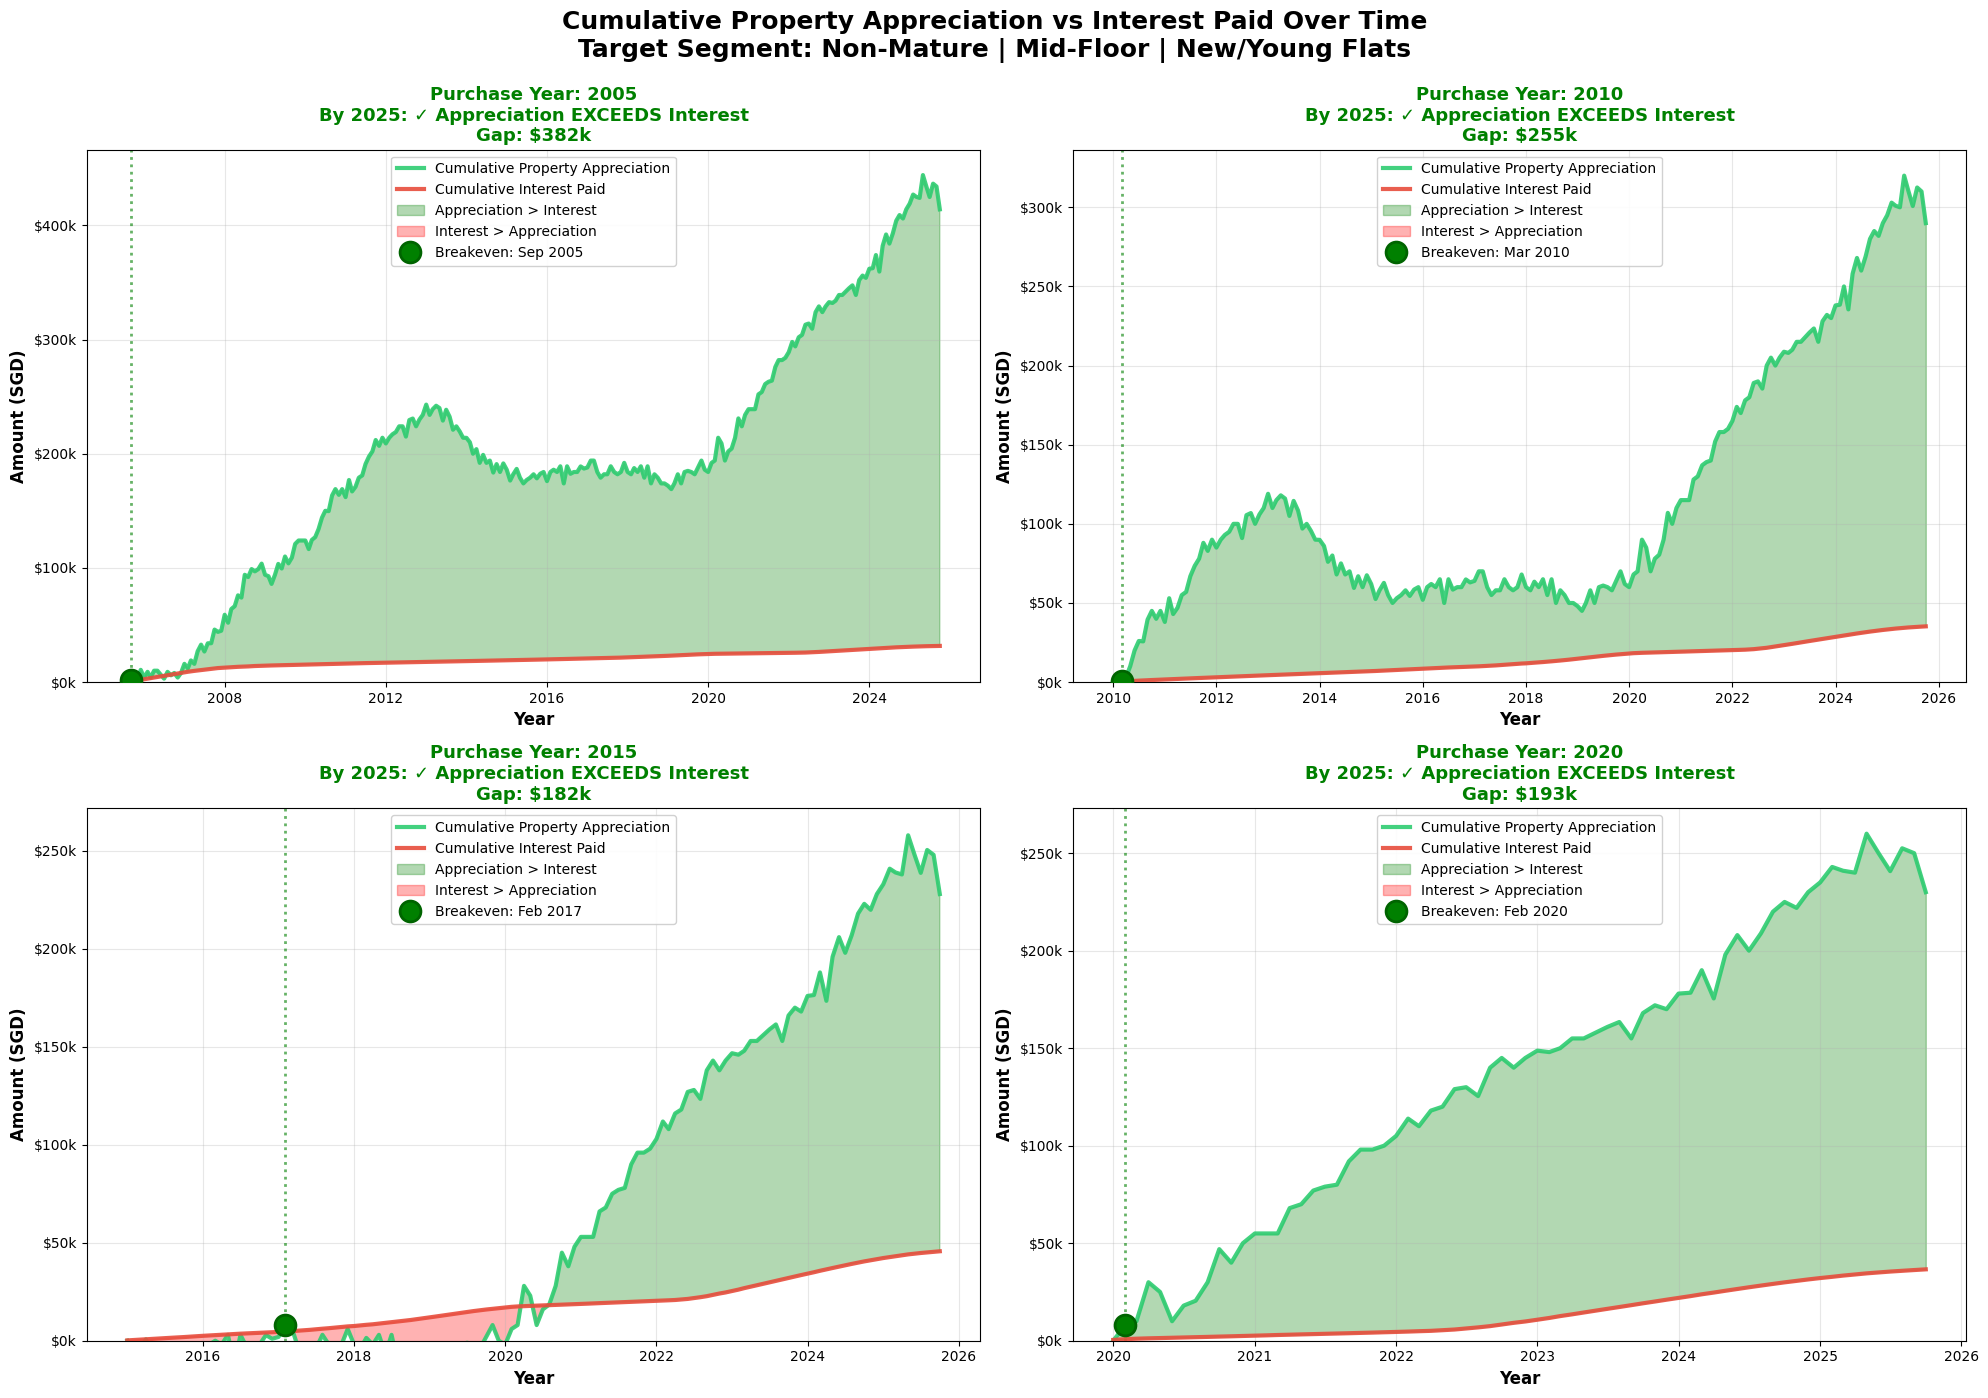

In [74]:
# ============================================================================
# VISUALIZATION: Cumulative Appreciation vs Interest Paid (2005-2020)
# ============================================================================
# Create a 2x2 grid of graphs, one for each purchase year
# Each graph shows two cumulative lines:
#   - Green line: Cumulative property appreciation over time
#   - Red line: Cumulative interest paid over time
# 
# NOTE: 2005 data starts from August 2005 (when SORA became available)

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Cumulative Property Appreciation vs Interest Paid Over Time\n' +
             'Target Segment: Non-Mature | Mid-Floor | New/Young Flats',
             fontsize=18, fontweight='bold', y=0.995)

# Loop through each purchase year and create a subplot
for idx, purchase_year in enumerate(purchase_years):
    # Calculate subplot position (row and column in the 2x2 grid)
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Check if simulation data exists for this purchase year
    if purchase_year not in all_scenarios:
        # Display "No Data" message if simulation failed
        ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14)
        ax.set_title(f'Purchase Year: {purchase_year}')
        continue
    
    # Get the simulation data for this purchase year
    scenario = all_scenarios[purchase_year]
    
    # Plot cumulative property appreciation (green line)
    ax.plot(scenario['date'], scenario['property_appreciation'], 
            label='Cumulative Property Appreciation', 
            color='#2ecc71', linewidth=3, alpha=0.9, zorder=3)
    
    # Plot cumulative interest paid (red line)
    ax.plot(scenario['date'], scenario['cumulative_interest_paid'], 
            label='Cumulative Interest Paid', 
            color='#e74c3c', linewidth=3, alpha=0.9, zorder=3)
    
    # Add shaded area where appreciation > interest (green = good)
    ax.fill_between(scenario['date'], 
                     scenario['property_appreciation'], 
                     scenario['cumulative_interest_paid'],
                     where=(scenario['property_appreciation'] >= scenario['cumulative_interest_paid']),
                     interpolate=True,
                     alpha=0.3, color='green', label='Appreciation > Interest')
    
    # Add shaded area where interest > appreciation (red = bad)
    ax.fill_between(scenario['date'], 
                     scenario['property_appreciation'], 
                     scenario['cumulative_interest_paid'],
                     where=(scenario['cumulative_interest_paid'] > scenario['property_appreciation']),
                     interpolate=True,
                     alpha=0.3, color='red', label='Interest > Appreciation')
    
    # Find breakeven points where appreciation overtakes interest
    diff = scenario['property_appreciation'] - scenario['cumulative_interest_paid']
    sign_changes = np.where(np.diff(np.sign(diff)))[0]
    
    # Mark the first breakeven point with a green dot
    if len(sign_changes) > 0:
        for cross_idx in sign_changes:
            if diff.iloc[cross_idx] < 0 and diff.iloc[cross_idx + 1] > 0:
                crossover_date = scenario.iloc[cross_idx + 1]['date']
                crossover_val = scenario.iloc[cross_idx + 1]['property_appreciation']
                ax.plot(crossover_date, crossover_val, 
                       'go', markersize=15, markeredgecolor='darkgreen', 
                       markeredgewidth=2, zorder=5,
                       label=f"Breakeven: {crossover_date.strftime('%b %Y')}")
                ax.axvline(x=crossover_date, color='green', linestyle=':', 
                          linewidth=2, alpha=0.6, zorder=2)
                break
    
    # Configure axis labels and formatting
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Amount (SGD)', fontsize=12, fontweight='bold')
    
    # Determine final status in 2025
    final_val = scenario.iloc[-1]
    final_appreciation = final_val['property_appreciation']
    final_interest = final_val['cumulative_interest_paid']
    
    if final_appreciation > final_interest:
        status = "✓ Appreciation EXCEEDS Interest"
        status_color = "green"
    else:
        status = "✗ Interest EXCEEDS Appreciation"
        status_color = "red"
    
    # Set subplot title with purchase year and final status
    ax.set_title(f'Purchase Year: {purchase_year}\n' +
                 f'By 2025: {status}\n' +
                 f'Gap: ${abs(final_appreciation - final_interest)/1000:.0f}k',
                 fontsize=13, fontweight='bold', color=status_color)
    
    # Format y-axis to show values in thousands (e.g., $200k)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
    
    # Add legend and grid
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Set y-axis to start from 0 for clarity
    ax.set_ylim(bottom=0)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## HDB Resale Price Stagnation (2013–2020)

Although graphs show that cumulative interest paid is generally lesser than the total appreciation of a flat, there are periods where this is not true.  
From **2013 to 2020**, HDB resale prices stagnated or even declined slightly due to several structural and policy factors.

---

### 1. Cooling Measures (2013 Onwards)

The biggest turning point came from government policies introduced around **2013** to curb overheating in the property market.

**Key Policies:**
- **Mortgage Servicing Ratio (MSR) cap (2013):**  
  Limits monthly housing loan repayments to **30% of gross income** for HDB buyers.  
  → Directly reduced borrowing power and affordability, lowering demand.
- **Tighter Loan-to-Value (LTV)** limits for second housing loans.
- **Additional Buyer’s Stamp Duty (ABSD):**  
  Although mainly targeted at private property, it cooled overall property sentiment.
- **Tightened HDB loan rules:**  
  HDB loans now capped by Total Debt Servicing Ratio (TDSR)-like rules.

**Effect:** These measures sharply reduced the pool of buyers who could afford higher-priced resale flats.

---

### 2. Shift in Demand — Rise of BTO Flats

After **2011**, the government ramped up **Build-To-Order (BTO)** supply to meet public housing demand.

- Between **2011 and 2015**, over **100,000 BTO flats** were launched.
- These new flats were **affordable** and often came with **generous grants**.
- Many first-time buyers preferred new flats over pricier resale units.

**Effect:** Demand for resale flats dropped significantly, pulling prices down.

---

### 3. Lease Decay Awareness

From around **2017** onward, Singaporeans became increasingly aware of **HDB lease decay** (since flats have 99-year leases).

- Public discussions and official statements highlighted that older flats could lose value as leases shorten.
- Buyers became more cautious about older resale flats, especially those with **less than 60

### Financial Risks of Taking the Maximum Loan

The **unpredictability of SORA rates** can create short-term financial strain for certain homeowners. This is particularly true when buyers opt for a **higher Loan-to-Value (LTV) ratio of 75%**, as the larger loan amount results in **higher monthly repayments** and increased financial pressure.

Additionally, **fluctuations in global or local economic conditions** can lead to **stagnation in HDB flat appreciation**. This was evident between **2013 and 2020**, when resale flat prices remained largely flat or experienced slight declines — underscoring the **volatility of property appreciation** over a prolonged period.

When a flat is purchased during such a stagnant phase, homeowners have **less flexibility to sell** in the short term. They may be **compelled to hold onto the property longer** until its value appreciates sufficiently to **break even or yield a profit** after accounting for cumulative interest payments.

Therefore, it is **not advisable to take the maximum available loan** when purchasing a flat. Adopting a more **conservative borrowing approach** offers greater financial resilience against potential interest rate hikes and market uncertainties.


## Limitations of the Analysis

While this analysis attempts to compare HDB resale price growth and interest rates across different segments, there are several important limitations to consider:

- **Price per Square Meter Calculation:**  
  The analysis determines the "correct" price per sqm for each segment by grouping transactions based on town maturity, floor level, and flat age, then calculating the median price per sqm for each group. However, this approach may not fully capture the nuances of the market. For example, government policy changes—such as the rule preventing former private property owners from buying 5-room HDB flats until 15 months after selling their private property—can significantly affect demand for certain flat types. As a result, simply comparing price per sqm across segments may not reflect true market dynamics, especially for 5-room flats versus others.

- **Segment Definitions and Representativeness:**  
  The chosen segments (e.g., mature vs non-mature towns, floor categories, age groups) are broad and may not account for all factors influencing flat prices, such as proximity to amenities, school zones, or unique estate characteristics. While broader segments help increase the sample size and reduce statistical noise, they may also mask important differences within each group. This means that the results, while useful for general trends, may not be fully representative of the specific factors affecting individual flat prices.

<b>Summary:</b>  
The analysis provides a useful overview of price and interest trends, but caution should be exercised when interpreting the results. Policy changes, market segmentation, and unaccounted factors can all influence the observed outcomes. A more granular analysis or additional data (e.g., on buyer profiles, flat attributes, or policy effects) would be needed for more precise conclusions.

# Part 2
Simulate buying scenario in 2023 (Young Couple DINK statistically most average graduate couple) - Eligible for 4-room BTO or mid-tier private condo at Sengkang or Punggol - show true lifetime homeownership cost BTO
- renovation
- stamp duties
- interest rate (maximum 75% LTV to show larger differences in financial burden)

## Average DINK of Graduates

Since there are no statistics to show the income of a couple before getting a BTO, the closest representation we can use is the Graduate Employment Survey to retrieve the monthly mean wages. 

It is still important to consider that majority of couples get a BTO after working for a period of time, so their wages might be higher than what is represented here.

Source: https://data.gov.sg/datasets/d_3c55210de27fcccda2ed0c63fdd2b352/view

In [75]:
# Load Graduate Employment Survey data
grad_employment_df = pd.read_csv('data/ges.csv')

print("Graduate Employment Survey loaded:")
print(f"Shape: {grad_employment_df.shape}")
print(f"Columns: {list(grad_employment_df.columns)}")

# Check available years
print(f"\nAvailable years: {sorted(grad_employment_df['year'].unique())}")

# Filter for 2023 data only
grad_2023 = grad_employment_df[grad_employment_df['year'] == 2023].copy()

print(f"\n2023 data shape: {grad_2023.shape}")
print(f"Number of degree programs in 2023: {len(grad_2023)}")

# Convert gross_monthly_mean to numeric, replacing non-numeric values with NaN
grad_2023['gross_monthly_mean'] = pd.to_numeric(grad_2023['gross_monthly_mean'], errors='coerce')

# Calculate average monthly income from 2023 data
# We'll use gross_monthly_mean as it includes base salary + other allowances
# Filter out any NaN values
valid_income_2023 = grad_2023['gross_monthly_mean'].dropna()

average_monthly_income_2023 = valid_income_2023.mean()
median_monthly_income_2023 = valid_income_2023.median()

print("\n" + "="*80)
print("2023 GRADUATE INCOME STATISTICS")
print("="*80)
print(f"Average Monthly Income (Gross Mean): ${average_monthly_income_2023:.2f}")
print(f"Median Monthly Income (Gross Mean): ${median_monthly_income_2023:.2f}")
print(f"Sample size: {len(valid_income_2023)} degree programs")

# For a DINK couple (two graduates)
couple_average_income = average_monthly_income_2023 * 2
couple_median_income = median_monthly_income_2023 * 2

print(f"\nFor a DINK couple (both fresh graduates in 2023):")
print(f"  Average Combined Monthly Income: ${couple_average_income:.2f}")
print(f"  Median Combined Monthly Income: ${couple_median_income:.2f}")

# Show some statistics
print("\n" + "="*80)
print("Income Distribution (2023):")
print(f"  Min: ${valid_income_2023.min():.2f}")
print(f"  25th percentile: ${valid_income_2023.quantile(0.25):.2f}")
print(f"  50th percentile (Median): ${valid_income_2023.quantile(0.50):.2f}")
print(f"  75th percentile: ${valid_income_2023.quantile(0.75):.2f}")
print(f"  Max: ${valid_income_2023.max():.2f}")

# Store the DINK for later use
DINK_2023 = couple_average_income


Graduate Employment Survey loaded:
Shape: (1401, 12)
Columns: ['year', 'university', 'school', 'degree', 'employment_rate_overall', 'employment_rate_ft_perm', 'basic_monthly_mean', 'basic_monthly_median', 'gross_monthly_mean', 'gross_monthly_median', 'gross_mthly_25_percentile', 'gross_mthly_75_percentile']

Available years: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

2023 data shape: (139, 12)
Number of degree programs in 2023: 139

2023 GRADUATE INCOME STATISTICS
Average Monthly Income (Gross Mean): $4550.89
Median Monthly Income (Gross Mean): $4303.00
Sample size: 132 degree programs

For a DINK couple (both fresh graduates in 2023):
  Average Combined Monthly Income: $9101.77
  Median Combined Monthly Income: $8606.00

Income Distribution (2023):
  Min: $3328.00
  25th percentile: $4025.50
  50th percentile (Median): $4303.00
  75th percentile: $4909

## Average cost of a BTO 

CSV file only contain data up till 2023, and only in limited areas.

We will only use Punggol prices for this scenario.

Source: https://data.gov.sg/collections/177/view

In [77]:
# Load BTO dataset
bto_df = pd.read_csv('data/bto.csv')

print("BTO Dataset loaded:")
print(f"Shape: {bto_df.shape}")
print(f"Columns: {list(bto_df.columns)}")

# Check available years and towns
print(f"\nAvailable years: {sorted(bto_df['financial_year'].unique())}")
print(f"\nAvailable towns: {sorted(bto_df['town'].unique())}")

# Filter for 2023 data in Punggol only
bto_2023 = bto_df[
    (bto_df['financial_year'] == 2023) &
    (bto_df['town'] == 'Punggol')
].copy()

print(f"\n2023 BTO data for Punggol:")
print(f"Shape: {bto_2023.shape}")

# Look at unique flat types
print(f"\nAvailable room types:")
print(bto_2023['room_type'].value_counts())

# Filter for 4-room flats (most common for DINK couples)
bto_2023_4room = bto_2023[bto_2023['room_type'] == '4-room'].copy()

print(f"\n4-Room BTO in 2023 (Punggol):")
print(f"Number of entries: {len(bto_2023_4room)}")

if len(bto_2023_4room) > 0:
    print("\n" + "="*80)
    print("4-ROOM BTO PRICES (2023 - Punggol, Without Grants)")
    print("="*80)
    
    # Display the data
    print("\nAvailable data:")
    print(bto_2023_4room[['town', 'room_type', 'min_selling_price', 'max_selling_price']])
    
    # Convert price columns to numeric (in case they're strings)
    bto_2023_4room['min_selling_price'] = pd.to_numeric(bto_2023_4room['min_selling_price'], errors='coerce')
    bto_2023_4room['max_selling_price'] = pd.to_numeric(bto_2023_4room['max_selling_price'], errors='coerce')
    
    # Calculate median of the range for each project
    bto_2023_4room['median_price'] = (bto_2023_4room['min_selling_price'] + bto_2023_4room['max_selling_price']) / 2
    
    # Overall median across all projects
    overall_median = bto_2023_4room['median_price'].median()
    overall_mean = bto_2023_4room['median_price'].mean()
    
    print(f"\n" + "="*80)
    print(f"Price Statistics (4-Room, Without Grants):")
    print(f"  Overall Median Price: ${overall_median:,.2f}")
    print(f"  Overall Mean Price: ${overall_mean:,.2f}")
    print(f"  Min Price (Lowest): ${bto_2023_4room['min_selling_price'].min():,.2f}")
    print(f"  Max Price (Highest): ${bto_2023_4room['max_selling_price'].max():,.2f}")
    
    # Store for later use
    bto_4room_price_2023 = overall_median
    
    print(f"\n" + "="*80)
    print(f"Using overall median price for analysis: ${bto_4room_price_2023:,.2f}")
    print("="*80)
else:
    print("\n⚠️ No 4-room BTO data found for Punggol in 2023")
    print("\nAll available 2023 data:")
    print(bto_2023)

BTO Dataset loaded:
Shape: (333, 7)
Columns: ['financial_year', 'town', 'room_type', 'min_selling_price', 'max_selling_price', 'min_selling_price_less_ahg_shg', 'max_selling_price_less_ahg_shg']

Available years: [np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

Available towns: ['Bukit Batok', 'Bukit Panjang', 'Choa Chu Kang', 'Hougang', 'Hougang ', 'Jurong East', 'Jurong West', 'Punggol', 'Sembawang', 'Sengkang', 'Tengah', 'Woodlands', 'Yishun']

2023 BTO data for Punggol:
Shape: (4, 7)

Available room types:
room_type
2-room    1
3-room    1
4-room    1
5-room    1
Name: count, dtype: int64

4-Room BTO in 2023 (Punggol):
Number of entries: 1

4-ROOM BTO PRICES (2023 - Punggol, Without Grants)

Available data:
        town room_type min_selling_price max_selling_price
323  Punggo

## Determining if Couple Can Afford 4-Room Condo

TDSR – Total Debt Servicing Ratio (for private property loans)

Total monthly debt repayments (housing + car + personal loans) must not exceed 55% of your gross monthly income. This is a legal cap set by MAS.

Assuming the couple does not have any other debts, we can calculate to see if buying a 4-room condo is sustainable, if not we will use the 3-room condo to compare with a 4-room BTO.

In [78]:
# ============================================================================
# LOAD CONDO DATASET FOR PUNGGOL
# ============================================================================
# Load condo dataset
condo_df = pd.read_csv('data/condo_2023.csv')

print("="*80)
print("CONDO DATASET LOADED")
print("="*80)
print(f"Shape: {condo_df.shape}")
print(f"Columns: {list(condo_df.columns)}")

# Check available Planning Areas
print(f"\nAvailable Planning Areas:")
if 'Planning Area' in condo_df.columns:
    print(condo_df['Planning Area'].value_counts())
else:
    print("'Planning Area' column not found. Available columns:")
    print(condo_df.columns.tolist())

# Filter for Punggol using the 'Planning Area' column
if 'Planning Area' in condo_df.columns:
    # Try multiple matching approaches to ensure we catch Punggol
    condo_punggol = condo_df[
        condo_df['Planning Area'].astype(str).str.strip().str.upper() == 'PUNGGOL'
    ].copy()
    print(f"\nFiltered for Punggol using 'Planning Area' column")
    print(f"Rows found: {len(condo_punggol)}")
else:
    print("\n⚠️ 'Planning Area' column not found. Cannot filter for Punggol.")
    condo_punggol = condo_df.copy()

print(f"\nCondo data for Punggol:")
print(f"Shape: {condo_punggol.shape}")

# Check for size/area columns
print(f"\nAvailable columns in Punggol data:")
print(condo_punggol.columns.tolist())

# Identify size column (could be 'area', 'floor_area_sqm', 'size_sqm', etc.)
size_col = None
for col in condo_punggol.columns:
    if 'sqm' in col.lower():
        size_col = col
        print(f"\nUsing size column: {size_col}")
        break

# Identify price column
price_col = None
for col in condo_punggol.columns:
    if 'price' in col.lower() and 'psf' not in col.lower() and 'psm' not in col.lower():
        price_col = col
        print(f"Using price column: {price_col}")
        break

if size_col and price_col:
    # Convert to numeric - first remove commas from the strings
    condo_punggol[size_col] = condo_punggol[size_col].astype(str).str.replace(',', '').replace('', None)
    condo_punggol[price_col] = condo_punggol[price_col].astype(str).str.replace(',', '').replace('', None)
    
    condo_punggol[size_col] = pd.to_numeric(condo_punggol[size_col], errors='coerce')
    condo_punggol[price_col] = pd.to_numeric(condo_punggol[price_col], errors='coerce')
    
    # Remove rows with NaN values in size or price
    condo_punggol = condo_punggol.dropna(subset=[size_col, price_col])
    
    # Debug: Show size distribution
    print(f"\n" + "="*80)
    print(f"SIZE DISTRIBUTION ANALYSIS")
    print(f"="*80)
    print(f"Size column: {size_col}")
    print(f"Valid rows after removing NaN: {len(condo_punggol)}")
    print(f"Min size: {condo_punggol[size_col].min()}")
    print(f"Max size: {condo_punggol[size_col].max()}")
    print(f"Mean size: {condo_punggol[size_col].mean():.2f}")
    print(f"Median size: {condo_punggol[size_col].median():.2f}")
    print(f"\nSize quantiles:")
    print(condo_punggol[size_col].describe())
    
    # Show ACTUAL units in the dataset - let's see what's there!
    print(f"\n" + "="*80)
    print(f"ACTUAL UNIT SIZES IN DATASET")
    print(f"="*80)
    print(f"\nAll unique sizes in the Punggol condo dataset:")
    unique_sizes = sorted(condo_punggol[size_col].unique())
    print(unique_sizes)
    
    print(f"\nUnits around 85-100 sqm range:")
    units_85_100 = condo_punggol[(condo_punggol[size_col] >= 85) & (condo_punggol[size_col] <= 100)]
    if len(units_85_100) > 0:
        print(units_85_100[[size_col, price_col]].to_string())
    else:
        print("No units found in 85-100 sqm range")
    
    print(f"\nCount of units by size:")
    print(condo_punggol[size_col].value_counts().sort_index())
    
    # Define size ranges for 3-room and 4-room equivalents
    # 3-room equivalent: 60-84 sqm
    # 4-room equivalent: 85-120 sqm
    
    condo_3room = condo_punggol[(condo_punggol[size_col] >= 60) & (condo_punggol[size_col] <= 84)].copy()
    condo_4room = condo_punggol[(condo_punggol[size_col] >= 85) & (condo_punggol[size_col] <= 120)].copy()
    
    print(f"\n" + "="*80)
    print(f"FILTERING RESULTS:")
    print(f"="*80)
    print(f"  Units between 60-84 sqm (3-room equiv): {len(condo_3room)}")
    if len(condo_3room) > 0:
        print(f"  Size range found: {condo_3room[size_col].min():.1f} - {condo_3room[size_col].max():.1f} sqm")
    
    print(f"\n  Units between 85-120 sqm (4-room equiv): {len(condo_4room)}")
    if len(condo_4room) > 0:
        print(f"  Size range found: {condo_4room[size_col].min():.1f} - {condo_4room[size_col].max():.1f} sqm")
        print(f"\n  Detailed 4-room units:")
        print(condo_4room[[size_col, price_col]].to_string())
    
    print("\n" + "="*80)
    print("CONDO PRICE ANALYSIS (Punggol, 2023)")
    print("="*80)
    
    # 3-room equivalent analysis
    if len(condo_3room) > 0:
        median_3room = condo_3room[price_col].median()
        mean_3room = condo_3room[price_col].mean()
        min_3room = condo_3room[price_col].min()
        max_3room = condo_3room[price_col].max()
        
        print(f"\n3-ROOM EQUIVALENT (60-84 sqm):")
        print(f"  Sample size: {len(condo_3room)} units")
        print(f"  Median Price: ${median_3room:,.2f}")
        print(f"  Mean Price: ${mean_3room:,.2f}")
        print(f"  Price Range: ${min_3room:,.2f} - ${max_3room:,.2f}")
        
        # Store for later use
        condo_3room_price_2023 = median_3room
    else:
        print(f"\n3-ROOM EQUIVALENT (60-84 sqm): No data found")
        condo_3room_price_2023 = None
    
    # 4-room equivalent analysis
    if len(condo_4room) > 0:
        median_4room = condo_4room[price_col].median()
        mean_4room = condo_4room[price_col].mean()
        min_4room = condo_4room[price_col].min()
        max_4room = condo_4room[price_col].max()
        
        print(f"\n4-ROOM EQUIVALENT (85-120 sqm):")
        print(f"  Sample size: {len(condo_4room)} units")
        print(f"  Median Price: ${median_4room:,.2f}")
        print(f"  Mean Price: ${mean_4room:,.2f}")
        print(f"  Price Range: ${min_4room:,.2f} - ${max_4room:,.2f}")
        
        # Store for later use
        condo_4room_price_2023 = median_4room
    else:
        print(f"\n4-ROOM EQUIVALENT (85-120 sqm): No data found")
        condo_4room_price_2023 = None
    
    print("\n" + "="*80)
    print("REPRESENTATIVE VALUES FOR ANALYSIS:")
    print("="*80)
    if condo_3room_price_2023:
        print(f"3-room condo (Punggol, 60-84 sqm): ${condo_3room_price_2023:,.2f}")
    if condo_4room_price_2023:
        print(f"4-room condo (Punggol, 85-120 sqm): ${condo_4room_price_2023:,.2f}")
    print("="*80)
    
else:
    print("\n⚠️ Could not identify size and price columns in the dataset.")
    print("Please check the data structure.")

CONDO DATASET LOADED
Shape: (1615, 21)
Columns: ['Project Name', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Type of Sale', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type', 'Number of Units', 'Tenure', 'Completion Date', 'Purchaser Address Indicator', 'Postal Code', 'Postal District', 'Postal Sector', 'Planning Region', 'Planning Area']

Available Planning Areas:
Planning Area
Hougang      827
Serangoon    459
Sengkang     171
Punggol      132
Toa Payoh     26
Name: count, dtype: int64

Filtered for Punggol using 'Planning Area' column
Rows found: 132

Condo data for Punggol:
Shape: (132, 21)

Available columns in Punggol data:
['Project Name', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Type of Sale', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type', 'Number of Units', 'Tenure', 'Completion Date', 'Purchaser Address Indicator', 'P

In [79]:
# ============================================================================
# VISUALIZATION: Monthly Loan Burden vs SORA Rates (2023-2025)
# ============================================================================
# This shows how much of the property value goes toward loan payments each month
# and how SORA fluctuations affect the burden

def calculate_loan_burden_over_time(property_price, loan_to_value, loan_tenure_years, start_date, end_date, monthly_sora_rates):
    """
    Calculate monthly loan payments and track them as a percentage of property value.
    
    Parameters:
    - property_price: Purchase price of the property
    - loan_to_value: LTV ratio (e.g., 0.75 for 75%)
    - loan_tenure_years: Loan tenure in years (e.g., 25)
    - start_date: Start date for calculation (e.g., pd.Timestamp('2023-01-01'))
    - end_date: End date for calculation (e.g., pd.Timestamp('2025-12-31'))
    - monthly_sora_rates: DataFrame with 'date' and 'SORA' columns
    
    Returns:
    - DataFrame with monthly payment breakdown
    """
    
    # Calculate loan amount
    loan_amount = property_price * loan_to_value
    downpayment = property_price * (1 - loan_to_value)
    
    # Get relevant SORA rates for the period
    relevant_sora = monthly_sora_rates[
        (monthly_sora_rates['date'] >= start_date) &
        (monthly_sora_rates['date'] <= end_date)
    ].copy().reset_index(drop=True)
    
    if len(relevant_sora) == 0:
        return None
    
    # Calculate month-by-month loan payments
    loan_data = []
    remaining_principal = loan_amount
    total_interest_paid = 0
    months_elapsed = 0
    bank_spread = 0.005  # 0.5% spread on SORA
    
    for idx, row in relevant_sora.iterrows():
        # Stop if loan is fully paid or tenure exceeded
        if remaining_principal <= 0.01 or months_elapsed >= loan_tenure_years * 12:
            remaining_principal = 0
            monthly_interest = 0
            monthly_payment = 0
            principal_payment = 0
        else:
            # Calculate monthly interest rate
            monthly_rate = (row['SORA'] + bank_spread * 100) / 12 / 100
            
            # Calculate monthly payment using amortization formula
            remaining_months = loan_tenure_years * 12 - months_elapsed
            if remaining_months > 0 and monthly_rate > 0:
                monthly_payment = remaining_principal * (
                    monthly_rate * (1 + monthly_rate)**remaining_months
                ) / ((1 + monthly_rate)**remaining_months - 1)
            else:
                monthly_payment = remaining_principal / max(remaining_months, 1)
            
            # Interest and principal portions
            monthly_interest = remaining_principal * monthly_rate
            principal_payment = monthly_payment - monthly_interest
            
            # Update totals
            total_interest_paid += monthly_interest
            remaining_principal = max(0, remaining_principal - principal_payment)
        
        # Calculate as percentage of property value
        monthly_payment_pct = (monthly_payment / property_price) * 100
        cumulative_paid_pct = ((loan_amount - remaining_principal) / property_price) * 100
        
        # Store monthly data
        loan_data.append({
            'date': row['date'],
            'sora_rate': row['SORA'],
            'monthly_payment': monthly_payment,
            'monthly_interest': monthly_interest,
            'principal_payment': principal_payment,
            'remaining_principal': remaining_principal,
            'cumulative_interest_paid': total_interest_paid,
            'monthly_payment_pct': monthly_payment_pct,
            'cumulative_paid_pct': cumulative_paid_pct,
            'months_elapsed': months_elapsed
        })
        
        months_elapsed += 1
    
    return pd.DataFrame(loan_data)

print("Function defined: calculate_loan_burden_over_time()")
print("Ready to calculate loan burden for 2023-2025...\n")

Function defined: calculate_loan_burden_over_time()
Ready to calculate loan burden for 2023-2025...



Calculating loan burden for condos...
  - 3-room condo...


Text(0.5, 1.0, 'Monthly Loan Payment Burden vs SORA Rate')

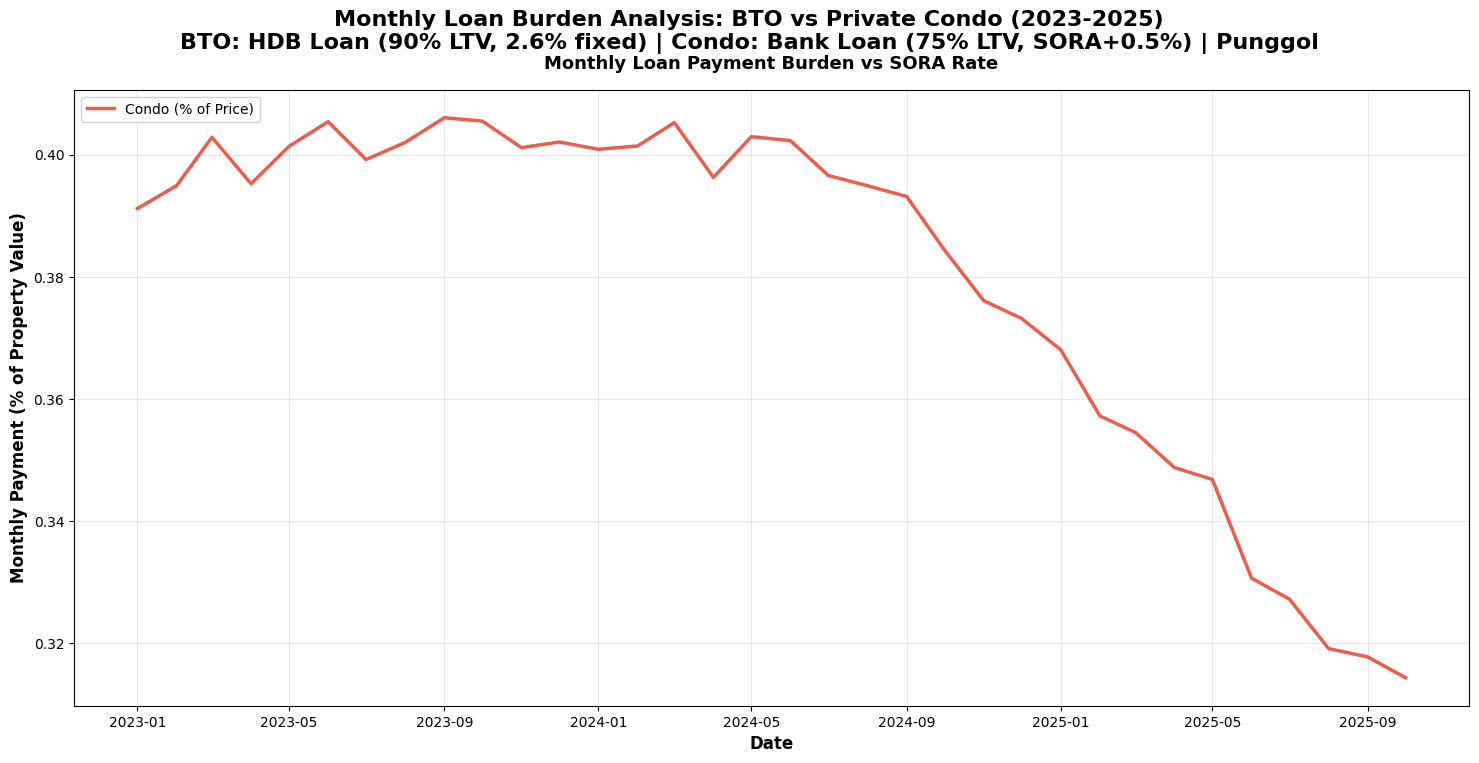

In [91]:
# ============================================================================
# CALCULATE AND VISUALIZE: Loan Burden for Condo (2023-2025)
# ============================================================================

# Define parameters
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2025-12-31')
ltv_ratio = 0.75  # 75% LTV (maximum)
loan_tenure = 25  # 25 years

# Calculate for both 3-room and 4-room Condos
print("Calculating loan burden for condos...")

# 3-room condo
if condo_3room_price_2023:
    print("  - 3-room condo...")
    condo_3room_burden = calculate_loan_burden_over_time(
        property_price=condo_3room_price_2023,
        loan_to_value=ltv_ratio,
        loan_tenure_years=loan_tenure,
        start_date=start_date,
        end_date=end_date,
        monthly_sora_rates=monthly_sora
    )
else:
    condo_3room_burden = None

# Use 3-room condo for comparison with BTO 4-room
condo_burden_to_plot = condo_3room_burden
condo_price_to_plot = condo_3room_price_2023
condo_type_to_plot = "3-room"

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))
fig.suptitle('Monthly Loan Burden Analysis: BTO vs Private Condo (2023-2025)\n' +
             f'BTO: HDB Loan (90% LTV, 2.6% fixed) | Condo: Bank Loan (75% LTV, SORA+0.5%) | Punggol',
             fontsize=16, fontweight='bold')

# ============================================================================
# Monthly Payment as % of Property Value + SORA Rate
# ============================================================================

lines = []

    
if condo_burden_to_plot is not None:
    # Plot Condo monthly payment percentage (using one representative condo)
    line2 = ax1.plot(condo_burden_to_plot['date'], condo_burden_to_plot['monthly_payment_pct'], 
                     label=f'Condo (% of Price)',
                     color='#e74c3c', linewidth=2.5, alpha=0.9)
    lines.extend(line2)

# Configure axes
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Monthly Payment (% of Property Value)', fontsize=12, fontweight='bold', color='black')

# Combine legends
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10, framealpha=0.9)

ax1.grid(True, alpha=0.3)
ax1.set_title('Monthly Loan Payment Burden vs SORA Rate', fontsize=13, fontweight='bold', pad=15)

In [86]:
# ============================================================================
# TDSR COMPLIANCE CHECK & RECOMMENDED LOAN BURDEN
# ============================================================================
# TDSR (Total Debt Servicing Ratio) = 55% for private property loans
# This is a regulatory cap by MAS (Monetary Authority of Singapore)
# 
# For affordability and financial prudence, we'll also check against:
# - 30% rule: Housing costs should not exceed 30% of gross income
# - 40% rule: More lenient threshold for higher earners

print("="*80)
print("TDSR COMPLIANCE & AFFORDABILITY ANALYSIS")
print("="*80)

# Define thresholds
TDSR_LIMIT = 0.55  # 55% regulatory cap for private property
PRUDENT_THRESHOLD = 0.30  # 30% prudent housing expense ratio
MODERATE_THRESHOLD = 0.40  # 40% moderate threshold

# Couple's monthly income (from earlier calculation)
monthly_income = DINK_2023
print(f"\nCouple's Combined Monthly Income: ${monthly_income:,.2f}")
print(f"\nRegulatory & Prudent Thresholds:")
print(f"  TDSR Limit (55%): ${monthly_income * TDSR_LIMIT:,.2f} per month")
print(f"  Moderate Threshold (40%): ${monthly_income * MODERATE_THRESHOLD:,.2f} per month")
print(f"  Prudent Threshold (30%): ${monthly_income * PRUDENT_THRESHOLD:,.2f} per month")

# ============================================================================
# 3-ROOM CONDO AFFORDABILITY CHECK
# ============================================================================
if condo_3room_burden is not None:
    print("\n" + "="*80)
    print("3-ROOM CONDO AFFORDABILITY (Punggol)")
    print("="*80)
    
    avg_monthly_3room = condo_3room_burden['monthly_payment'].mean()
    min_monthly_3room = condo_3room_burden['monthly_payment'].min()
    max_monthly_3room = condo_3room_burden['monthly_payment'].max()
    
    # Calculate as percentage of income
    avg_pct_income_3room = (avg_monthly_3room / monthly_income) * 100
    min_pct_income_3room = (min_monthly_3room / monthly_income) * 100
    max_pct_income_3room = (max_monthly_3room / monthly_income) * 100
    
    print(f"\nProperty Price: ${condo_3room_price_2023:,.2f}")
    print(f"Loan Amount (75% LTV): ${condo_3room_price_2023 * 0.75:,.2f}")
    print(f"\nMonthly Loan Payment (2023-2025):")
    print(f"  Average: ${avg_monthly_3room:,.2f} ({avg_pct_income_3room:.2f}% of income)")
    print(f"  Range: ${min_monthly_3room:,.2f} - ${max_monthly_3room:,.2f}")
    print(f"  Range: {min_pct_income_3room:.2f}% - {max_pct_income_3room:.2f}% of income")
    
    print(f"\n✓ AFFORDABILITY ASSESSMENT:")
    
    # Check against thresholds
    if avg_pct_income_3room <= PRUDENT_THRESHOLD * 100:
        print(f"  ✅ EXCELLENT - Well within prudent 30% threshold")
        print(f"     Recommended loan burden: Use this as benchmark")
    elif avg_pct_income_3room <= MODERATE_THRESHOLD * 100:
        print(f"  ✅ GOOD - Within moderate 40% threshold")
        print(f"     Manageable with some financial discipline")
    elif avg_pct_income_3room <= TDSR_LIMIT * 100:
        print(f"  ⚠️  ACCEPTABLE - Below TDSR 55% limit but stretching budget")
        print(f"     May face financial stress if income drops or expenses rise")
    else:
        print(f"  ❌ EXCEEDS TDSR - Above 55% regulatory limit")
        print(f"     CANNOT obtain bank loan legally")
    
    # Additional financial cushion analysis
    remaining_income_3room = monthly_income - avg_monthly_3room
    print(f"\nRemaining Monthly Income (after loan): ${remaining_income_3room:,.2f}")
    print(f"  This must cover: Food, transport, utilities, insurance, savings, emergencies")

# ============================================================================
# 4-ROOM CONDO AFFORDABILITY CHECK
# ============================================================================
if condo_4room_burden is not None:
    print("\n" + "="*80)
    print("4-ROOM CONDO AFFORDABILITY (Punggol)")
    print("="*80)
    
    avg_monthly_4room = condo_4room_burden['monthly_payment'].mean()
    min_monthly_4room = condo_4room_burden['monthly_payment'].min()
    max_monthly_4room = condo_4room_burden['monthly_payment'].max()
    
    # Calculate as percentage of income
    avg_pct_income_4room = (avg_monthly_4room / monthly_income) * 100
    min_pct_income_4room = (min_monthly_4room / monthly_income) * 100
    max_pct_income_4room = (max_monthly_4room / monthly_income) * 100
    
    print(f"\nProperty Price: ${condo_4room_price_2023:,.2f}")
    print(f"Loan Amount (75% LTV): ${condo_4room_price_2023 * 0.75:,.2f}")
    print(f"\nMonthly Loan Payment (2023-2025):")
    print(f"  Average: ${avg_monthly_4room:,.2f} ({avg_pct_income_4room:.2f}% of income)")
    print(f"  Range: ${min_monthly_4room:,.2f} - ${max_monthly_4room:,.2f}")
    print(f"  Range: {min_pct_income_4room:.2f}% - {max_pct_income_4room:.2f}% of income")
    
    print(f"\n✓ AFFORDABILITY ASSESSMENT:")
    
    # Check against thresholds
    if avg_pct_income_4room <= PRUDENT_THRESHOLD * 100:
        print(f"  ✅ EXCELLENT - Well within prudent 30% threshold")
        print(f"     Recommended loan burden: Use this as benchmark")
    elif avg_pct_income_4room <= MODERATE_THRESHOLD * 100:
        print(f"  ✅ GOOD - Within moderate 40% threshold")
        print(f"     Manageable with some financial discipline")
    elif avg_pct_income_4room <= TDSR_LIMIT * 100:
        print(f"  ⚠️  ACCEPTABLE - Below TDSR 55% limit but stretching budget")
        print(f"     May face financial stress if income drops or expenses rise")
    else:
        print(f"  ❌ EXCEEDS TDSR - Above 55% regulatory limit")
        print(f"     CANNOT obtain bank loan legally")
    
    # Additional financial cushion analysis
    remaining_income_4room = monthly_income - avg_monthly_4room
    print(f"\nRemaining Monthly Income (after loan): ${remaining_income_4room:,.2f}")
    print(f"  This must cover: Food, transport, utilities, insurance, savings, emergencies")

# ============================================================================
# COMPARISON & RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("COMPARISON & RECOMMENDATION")
print("="*80)

print(f"\n📊 RECOMMENDED LOAN BURDEN GUIDELINE:")
print(f"   • Prudent (30%): Housing costs ≤ ${monthly_income * PRUDENT_THRESHOLD:,.2f}/month")
print(f"   • Moderate (40%): Housing costs ≤ ${monthly_income * MODERATE_THRESHOLD:,.2f}/month")
print(f"   • Maximum (55% TDSR): Housing costs ≤ ${monthly_income * TDSR_LIMIT:,.2f}/month")

if bto_burden is not None:
    print(f"\n💰 MONTHLY PAYMENT COMPARISON:")
    print(f"   BTO 4-room: ${bto_burden['monthly_payment'].mean():,.2f} ({(bto_burden['monthly_payment'].mean()/monthly_income)*100:.2f}% of income)")
    
if condo_3room_burden is not None:
    print(f"   Condo 3-room: ${avg_monthly_3room:,.2f} ({avg_pct_income_3room:.2f}% of income)")
    if bto_burden is not None:
        print(f"      vs BTO: +${avg_monthly_3room - bto_burden['monthly_payment'].mean():,.2f}/month ({(avg_monthly_3room - bto_burden['monthly_payment'].mean())*12:,.2f}/year)")
    
if condo_4room_burden is not None:
    print(f"   Condo 4-room: ${avg_monthly_4room:,.2f} ({avg_pct_income_4room:.2f}% of income)")
    if bto_burden is not None:
        print(f"      vs BTO: +${avg_monthly_4room - bto_burden['monthly_payment'].mean():,.2f}/month ({(avg_monthly_4room - bto_burden['monthly_payment'].mean())*12:,.2f}/year)")

print(f"\n🎯 RECOMMENDATION:")

if bto_burden is not None:
    avg_pct_income_bto = (bto_burden['monthly_payment'].mean() / monthly_income) * 100
    if avg_pct_income_bto <= PRUDENT_THRESHOLD * 100:
        print(f"   ✅ BTO is highly affordable and provides excellent financial flexibility")
        print(f"   ✅ Leaves {100 - avg_pct_income_bto:.1f}% of income for other expenses and savings")

if condo_3room_burden is not None:    
    if avg_pct_income_3room <= MODERATE_THRESHOLD * 100:
        print(f"   ✅ 3-room Condo is affordable but reduces financial flexibility")
        print(f"   ⚠️  Leaves only {100 - avg_pct_income_3room:.1f}% of income for other expenses")
    elif avg_pct_income_3room <= TDSR_LIMIT * 100:
        print(f"   ⚠️  3-room Condo stretches the budget significantly")
        print(f"   ⚠️  Only {100 - avg_pct_income_3room:.1f}% of income remains for other needs")
        print(f"   ⚠️  Financial stress likely if income drops or expenses rise")
    else:
        print(f"   ❌ 3-room Condo is NOT affordable - exceeds TDSR limit")
        print(f"   ❌ Bank will NOT approve 75% LTV loan")
        print(f"   💡 Consider: Lower LTV, cheaper property, or wait for higher income")

if condo_4room_burden is not None:    
    if avg_pct_income_4room <= MODERATE_THRESHOLD * 100:
        print(f"   ✅ 4-room Condo is affordable but reduces financial flexibility")
        print(f"   ⚠️  Leaves only {100 - avg_pct_income_4room:.1f}% of income for other expenses")
    elif avg_pct_income_4room <= TDSR_LIMIT * 100:
        print(f"   ⚠️  4-room Condo stretches the budget significantly")
        print(f"   ⚠️  Only {100 - avg_pct_income_4room:.1f}% of income remains for other needs")
        print(f"   ⚠️  Financial stress likely if income drops or expenses rise")
    else:
        print(f"   ❌ 4-room Condo is NOT affordable - exceeds TDSR limit")
        print(f"   ❌ Bank will NOT approve 75% LTV loan")
        print(f"   💡 Consider: Lower LTV, cheaper property, or wait for higher income")

print("\n" + "="*80)
print("⚠️  IMPORTANT CONSIDERATIONS:")
print("="*80)
print("• SORA rates are VARIABLE - your monthly payment will fluctuate")
print("• This analysis assumes NO other debts (car loans, personal loans, etc.)")
print("• Additional costs: Property tax, maintenance, insurance, sinking fund")
print("• Condo: Additional monthly maintenance fees (~$200-400/month)")
print("• Emergency fund: Should have 6-12 months of expenses saved")
print("• Life changes: Marriage, children, job changes affect affordability")
print("="*80)

TDSR COMPLIANCE & AFFORDABILITY ANALYSIS

Couple's Combined Monthly Income: $9,101.77

Regulatory & Prudent Thresholds:
  TDSR Limit (55%): $5,005.98 per month
  Moderate Threshold (40%): $3,640.71 per month
  Prudent Threshold (30%): $2,730.53 per month

3-ROOM CONDO AFFORDABILITY (Punggol)

Property Price: $1,110,000.00
Loan Amount (75% LTV): $832,500.00

Monthly Loan Payment (2023-2025):
  Average: $4,217.61 (46.34% of income)
  Range: $3,489.46 - $4,507.10
  Range: 38.34% - 49.52% of income

✓ AFFORDABILITY ASSESSMENT:
  ⚠️  ACCEPTABLE - Below TDSR 55% limit but stretching budget
     May face financial stress if income drops or expenses rise

Remaining Monthly Income (after loan): $4,884.16
  This must cover: Food, transport, utilities, insurance, savings, emergencies

4-ROOM CONDO AFFORDABILITY (Punggol)

Property Price: $1,438,000.00
Loan Amount (75% LTV): $1,078,500.00

Monthly Loan Payment (2023-2025):
  Average: $5,463.90 (60.03% of income)
  Range: $4,520.58 - $5,838.93
  Ra

Since there are instances where the loan payment is above the TDSR, it can be concluded that an average graduate DINK is not sufficient for 4-room condo. We will use 3-room condo for analysis. although it is not advisable

## Renovation

There is no data on how much Singaporeans spend on their renovations. However, there has been a guide done by a company 'homematch', which managed to estimate renovation costs.

Their methodology is logical and since this the best representation of renovations that we can get, we will use the median of their estimated renovation cost.

Source: https://www.homematch.sg/renovation-guides/latest-average-renovation-cost-in-singapore#latest-average-renovation-costs-methodology

In [113]:
# Based of the range given by the source, median of the range is used
renovation_cost_hdb = (40300 + 62300) / 2 # 4-room
renovation_cost_condo = (68500 + 32200) / 2 # 3-room

## 3-Room Condo vs 4-Room BTO Cumulative Financial Burden

We will now simulate a couple buying a 3-room condo and 4-room BTO with the following factors into consideration:
- DINK of $9,101.77
- Buying a property in Punggol
- Renovation costs, stamp duties
- Interest of housing loan over a span of 25 years (HDB loan for BTO, bank loan for condo)


In [114]:
# ============================================================================
# CALCULATE STAMP DUTY (BSD - Buyer's Stamp Duty)
# ============================================================================
# Singapore stamp duty rates for property purchases

def calculate_stamp_duty(property_price):
    """
    Calculate Buyer's Stamp Duty (BSD) based on Singapore's progressive rates.
    
    Rates:
    - First $180,000: 1%
    - Next $180,000: 2%
    - Next $640,000: 3%
    - Next $500,000: 4%
    - Next $1,500,000: 5%
    - Remaining amount: 6%
    """
    
    brackets = [
        (180000, 0.01),
        (180000, 0.02),
        (640000, 0.03),
        (500000, 0.04),
        (1500000, 0.05),
        (float('inf'), 0.06)
    ]
    
    stamp_duty = 0
    remaining = property_price
    
    for bracket_amount, rate in brackets:
        if remaining <= 0:
            break
        
        taxable = min(remaining, bracket_amount)
        stamp_duty += taxable * rate
        remaining -= taxable
    
    return stamp_duty

# Test the function
print("Stamp Duty Calculator Test:")
print(f"  Property at $500,000: ${calculate_stamp_duty(500000):,.2f}")
print(f"  Property at $1,000,000: ${calculate_stamp_duty(1000000):,.2f}")
print(f"  Property at $1,500,000: ${calculate_stamp_duty(1500000):,.2f}")


Stamp Duty Calculator Test:
  Property at $500,000: $9,600.00
  Property at $1,000,000: $24,600.00
  Property at $1,500,000: $44,600.00


In [115]:
# ============================================================================
# CALCULATE CUMULATIVE PAYMENTS (Upfront + Monthly Loan Payments)
# ============================================================================

def calculate_cumulative_payments(property_price, loan_burden_df, renovation_cost=30000):
    """
    Calculate cumulative payments over time including:
    - Downpayment (25% for private, 10% for HDB)
    - Stamp duty
    - Renovation costs
    - Monthly loan payments (cumulative)
    
    Parameters:
    - property_price: Purchase price of the property
    - loan_burden_df: DataFrame from calculate_loan_burden_over_time()
    - renovation_cost: Estimated renovation cost (default: $30,000)
    
    Returns:
    - DataFrame with cumulative payment breakdown
    """
    
    if loan_burden_df is None or len(loan_burden_df) == 0:
        return None
    
    # Calculate upfront costs
    downpayment = property_price * 0.25  # 25% for private property
    stamp_duty = calculate_stamp_duty(property_price)
    upfront_costs = downpayment + stamp_duty + renovation_cost
    
    # Build cumulative payment timeline
    cumulative_data = []
    
    for idx, row in loan_burden_df.iterrows():
        # Cumulative loan payments so far
        cumulative_loan = (row['months_elapsed'] + 1) * row['monthly_payment'] if row['months_elapsed'] == 0 else \
                          loan_burden_df.iloc[:idx+1]['monthly_payment'].sum()
        
        # Total cumulative payment
        total_cumulative = upfront_costs + cumulative_loan
        
        cumulative_data.append({
            'date': row['date'],
            'upfront_costs': upfront_costs,
            'downpayment': downpayment,
            'stamp_duty': stamp_duty,
            'renovation': renovation_cost,
            'cumulative_loan_payments': cumulative_loan,
            'total_cumulative_payment': total_cumulative,
            'months_elapsed': row['months_elapsed']
        })
    
    return pd.DataFrame(cumulative_data)

print("Function defined: calculate_cumulative_payments()")


Function defined: calculate_cumulative_payments()


In [118]:
# ============================================================================
# CALCULATE CUMULATIVE PAYMENTS FOR BTO AND CONDO
# ============================================================================

print("="*80)
print("CALCULATING CUMULATIVE PAYMENTS (2023-2025)")
print("="*80)

# ============================================================================
# BTO - HDB Loan with FIXED 2.6% interest rate
# ============================================================================
print("\nBTO 4-room (Punggol) - HDB Loan @ 2.6% fixed:")
bto_downpayment = bto_4room_price_2023 * 0.10  # 10% for HDB
bto_stamp_duty = calculate_stamp_duty(bto_4room_price_2023)
bto_upfront = bto_downpayment + bto_stamp_duty + renovation_cost_hdb

print(f"  Property Price: ${bto_4room_price_2023:,.2f}")
print(f"  Downpayment (10%): ${bto_downpayment:,.2f}")
print(f"  Stamp Duty: ${bto_stamp_duty:,.2f}")
print(f"  Renovation: ${renovation_cost_hdb:,.2f}")
print(f"  Total Upfront: ${bto_upfront:,.2f}")
print(f"  Verification: ${bto_downpayment:,.2f} + ${bto_stamp_duty:,.2f} + ${renovation_cost_hdb:,.2f} = ${bto_upfront:,.2f}")

# Calculate BTO loan with HDB's fixed 2.6% rate
ltv_ratio_hdb = 0.90  # 90% LTV for HDB loan
bto_loan_amount = bto_4room_price_2023 * ltv_ratio_hdb
hdb_annual_rate = 0.026  # 2.6% per annum
hdb_monthly_rate = hdb_annual_rate / 12
loan_tenure = 25  # 25 years
total_months = loan_tenure * 12

# Calculate FIXED monthly payment (stays constant throughout loan)
if hdb_monthly_rate > 0:
    bto_fixed_monthly_payment = bto_loan_amount * (
        hdb_monthly_rate * (1 + hdb_monthly_rate)**total_months
    ) / ((1 + hdb_monthly_rate)**total_months - 1)
else:
    bto_fixed_monthly_payment = bto_loan_amount / total_months

print(f"  Loan Amount (90% LTV): ${bto_loan_amount:,.2f}")
print(f"  Fixed Monthly Payment: ${bto_fixed_monthly_payment:,.2f}")
print(f"  Interest Rate: 2.6% per annum (FIXED)")

# Get date range for 2023-2025
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2025-12-31')
relevant_dates = monthly_sora[
    (monthly_sora['date'] >= start_date) &
    (monthly_sora['date'] <= end_date)
].copy().reset_index(drop=True)

# Calculate month-by-month for BTO
bto_loan_data = []
remaining_principal = bto_loan_amount
total_interest_paid = 0

for idx, row in relevant_dates.iterrows():
    if remaining_principal <= 0.01 or idx >= total_months:
        remaining_principal = 0
        monthly_interest = 0
        monthly_payment = 0
        principal_payment = 0
    else:
        # Monthly payment is FIXED
        monthly_payment = bto_fixed_monthly_payment
        
        # Interest is calculated on remaining principal
        monthly_interest = remaining_principal * hdb_monthly_rate
        
        # Principal payment is the difference
        principal_payment = monthly_payment - monthly_interest
        
        # Update totals
        total_interest_paid += monthly_interest
        remaining_principal = max(0, remaining_principal - principal_payment)
    
    bto_loan_data.append({
        'date': row['date'],
        'monthly_payment': monthly_payment,
        'monthly_interest': monthly_interest,
        'principal_payment': principal_payment,
        'remaining_principal': remaining_principal,
        'cumulative_interest_paid': total_interest_paid,
        'months_elapsed': idx
    })

bto_burden_hdb = pd.DataFrame(bto_loan_data)

# Calculate cumulative payments for BTO
bto_cumulative = bto_burden_hdb.copy()
bto_cumulative['upfront_costs'] = bto_upfront
bto_cumulative['cumulative_loan_payments'] = bto_cumulative['monthly_payment'].cumsum()
bto_cumulative['total_cumulative_payment'] = bto_upfront + bto_cumulative['cumulative_loan_payments']

# ============================================================================
# Condo - Bank Loan with SORA-based variable rate
# ============================================================================
if condo_burden_to_plot is not None:
    print(f"\nCondo {condo_type_to_plot} (Punggol):")
    condo_downpayment = condo_price_to_plot * 0.25  # 25% for private property
    condo_stamp_duty = calculate_stamp_duty(condo_price_to_plot)
    condo_upfront = condo_downpayment + condo_stamp_duty + renovation_cost_condo
    
    print(f"  Property Price: ${condo_price_to_plot:,.2f}")
    print(f"  Downpayment (25%): ${condo_downpayment:,.2f}")
    print(f"  Stamp Duty: ${condo_stamp_duty:,.2f}")
    print(f"  Renovation: ${renovation_cost_condo:,.2f}")
    print(f"  Total Upfront: ${condo_upfront:,.2f}")
    print(f"  Verification: ${condo_downpayment:,.2f} + ${condo_stamp_duty:,.2f} + ${renovation_cost_condo:,.2f} = ${condo_upfront:,.2f}")
    
    # Calculate cumulative payments
    condo_cumulative = condo_burden_to_plot.copy()
    condo_cumulative['upfront_costs'] = condo_upfront
    condo_cumulative['cumulative_loan_payments'] = condo_cumulative['monthly_payment'].cumsum()
    condo_cumulative['total_cumulative_payment'] = condo_upfront + condo_cumulative['cumulative_loan_payments']

print("\n✓ Cumulative payment calculations complete!")


CALCULATING CUMULATIVE PAYMENTS (2023-2025)

BTO 4-room (Punggol) - HDB Loan @ 2.6% fixed:
  Property Price: $373,500.00
  Downpayment (10%): $37,350.00
  Stamp Duty: $5,805.00
  Renovation: $51,300.00
  Total Upfront: $94,455.00
  Verification: $37,350.00 + $5,805.00 + $51,300.00 = $94,455.00
  Loan Amount (90% LTV): $336,150.00
  Fixed Monthly Payment: $1,525.01
  Interest Rate: 2.6% per annum (FIXED)

Condo 3-room (Punggol):
  Property Price: $1,110,000.00
  Downpayment (25%): $277,500.00
  Stamp Duty: $29,000.00
  Renovation: $50,350.00
  Total Upfront: $356,850.00
  Verification: $277,500.00 + $29,000.00 + $50,350.00 = $356,850.00

✓ Cumulative payment calculations complete!


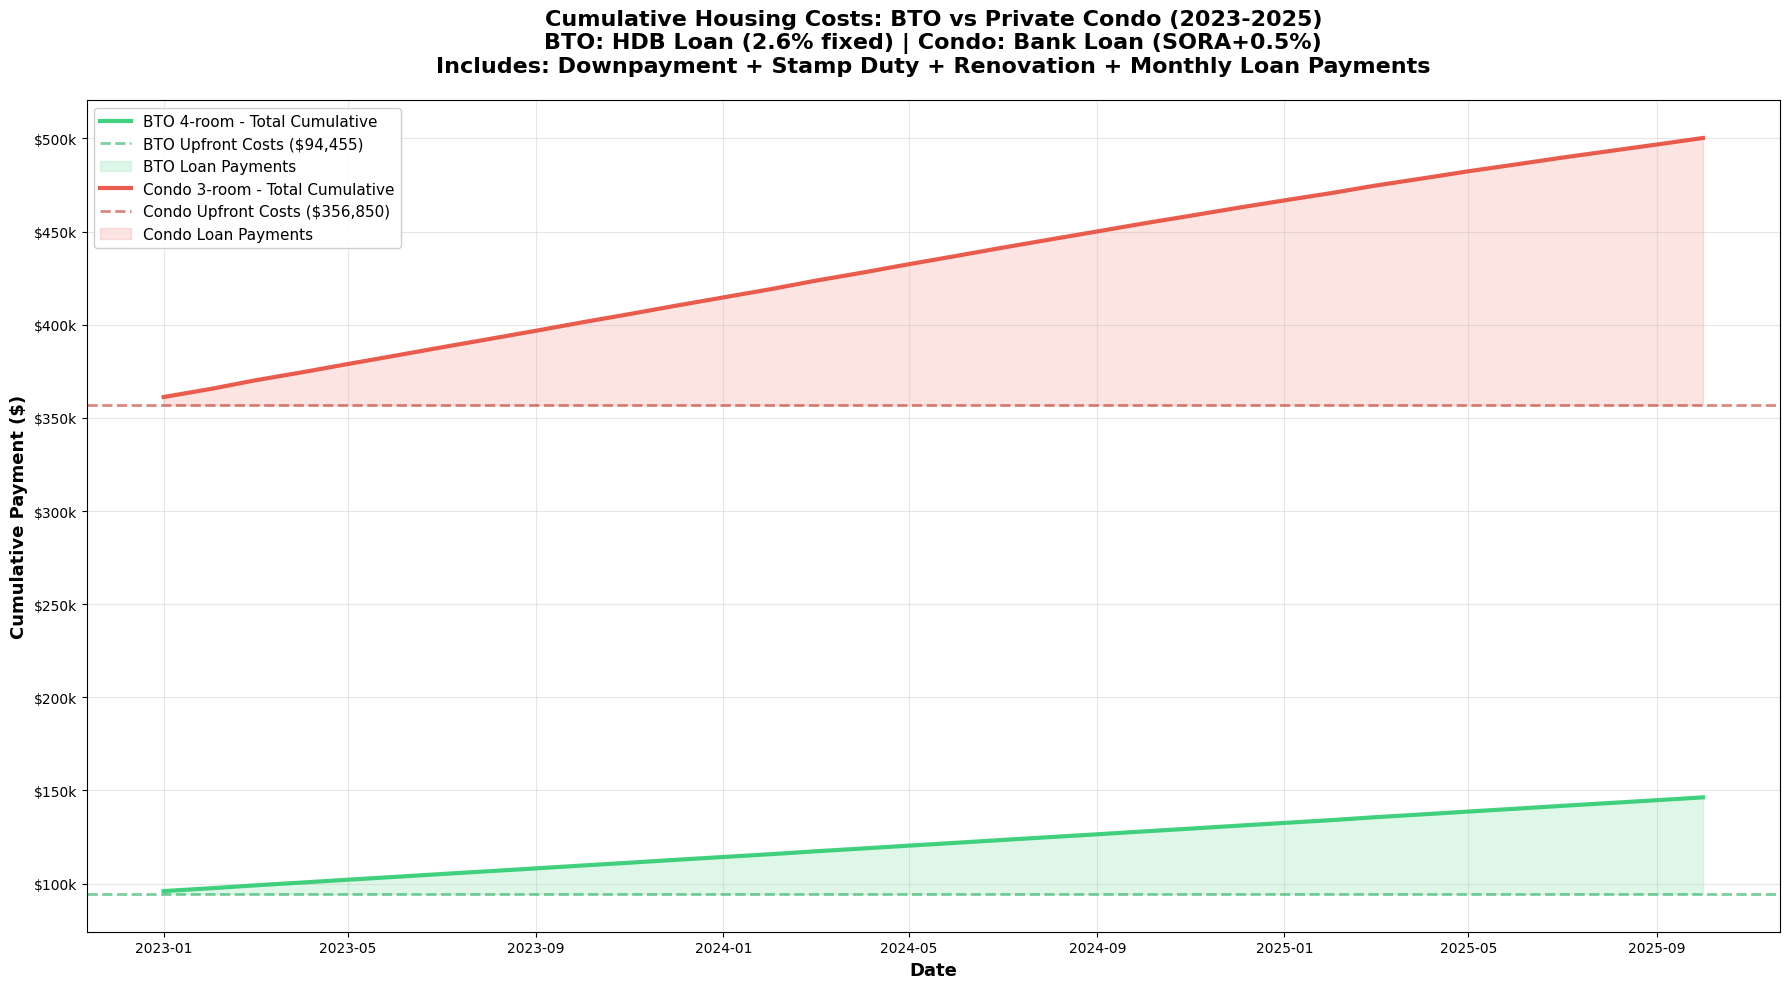


CUMULATIVE PAYMENT SUMMARY (End of 2025)

BTO 4-room (HDB Loan @ 2.6% fixed):
  Upfront Costs: $94,455.00
  Loan Payments (3 years): $51,850.34
  Total Paid: $146,305.34
  Percentage of Property Value: 39.2%

Condo 3-room (Bank Loan @ SORA+0.5%):
  Upfront Costs: $356,850.00
  Loan Payments (3 years): $143,398.81
  Total Paid: $500,248.81
  Percentage of Property Value: 45.1%

Difference (Condo - BTO): $353,943.47
  Condo costs 241.9% MORE than BTO


In [119]:
# ============================================================================
# VISUALIZE: CUMULATIVE PAYMENTS OVER TIME (2023-2025)
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

# Plot BTO cumulative payments
if bto_burden_hdb is not None:
    # Total cumulative
    ax.plot(bto_cumulative['date'], bto_cumulative['total_cumulative_payment'], 
            label=f'BTO 4-room - Total Cumulative', 
            color='#2ecc71', linewidth=3, alpha=0.9)
    
    # Upfront costs (horizontal line)
    ax.axhline(y=bto_upfront, color='#27ae60', linestyle='--', linewidth=2, 
               label=f'BTO Upfront Costs (${bto_upfront:,.0f})', alpha=0.6)
    
    # Fill area between upfront and total
    ax.fill_between(bto_cumulative['date'], 
                     bto_upfront, 
                     bto_cumulative['total_cumulative_payment'],
                     color='#2ecc71', alpha=0.15, 
                     label='BTO Loan Payments')

# Plot Condo cumulative payments
if condo_burden_to_plot is not None:
    # Total cumulative
    ax.plot(condo_cumulative['date'], condo_cumulative['total_cumulative_payment'], 
            label=f'Condo {condo_type_to_plot} - Total Cumulative', 
            color='#e74c3c', linewidth=3, alpha=0.9)
    
    # Upfront costs (horizontal line)
    ax.axhline(y=condo_upfront, color='#c0392b', linestyle='--', linewidth=2, 
               label=f'Condo Upfront Costs (${condo_upfront:,.0f})', alpha=0.6)
    
    # Fill area between upfront and total
    ax.fill_between(condo_cumulative['date'], 
                     condo_upfront, 
                     condo_cumulative['total_cumulative_payment'],
                     color='#e74c3c', alpha=0.15, 
                     label='Condo Loan Payments')

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Payment ($)', fontsize=13, fontweight='bold')
ax.set_title('Cumulative Housing Costs: BTO vs Private Condo (2023-2025)\n' +
             'BTO: HDB Loan (2.6% fixed) | Condo: Bank Loan (SORA+0.5%)\n' +
             'Includes: Downpayment + Stamp Duty + Renovation + Monthly Loan Payments',
             fontsize=16, fontweight='bold', pad=20)

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# Legend
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CUMULATIVE PAYMENT SUMMARY (End of 2025)")
print("="*80)

if bto_burden_hdb is not None:
    bto_final = bto_cumulative.iloc[-1]
    print(f"\nBTO 4-room (HDB Loan @ 2.6% fixed):")
    print(f"  Upfront Costs: ${bto_upfront:,.2f}")
    print(f"  Loan Payments (3 years): ${bto_final['cumulative_loan_payments']:,.2f}")
    print(f"  Total Paid: ${bto_final['total_cumulative_payment']:,.2f}")
    print(f"  Percentage of Property Value: {(bto_final['total_cumulative_payment']/bto_4room_price_2023)*100:.1f}%")

if condo_burden_to_plot is not None:
    condo_final = condo_cumulative.iloc[-1]
    print(f"\nCondo {condo_type_to_plot} (Bank Loan @ SORA+0.5%):")
    print(f"  Upfront Costs: ${condo_upfront:,.2f}")
    print(f"  Loan Payments (3 years): ${condo_final['cumulative_loan_payments']:,.2f}")
    print(f"  Total Paid: ${condo_final['total_cumulative_payment']:,.2f}")
    print(f"  Percentage of Property Value: {(condo_final['total_cumulative_payment']/condo_price_to_plot)*100:.1f}%")

if bto_burden_hdb is not None and condo_burden_to_plot is not None:
    difference = condo_final['total_cumulative_payment'] - bto_final['total_cumulative_payment']
    print(f"\nDifference (Condo - BTO): ${difference:,.2f}")
    print(f"  Condo costs {(difference/bto_final['total_cumulative_payment'])*100:.1f}% MORE than BTO")


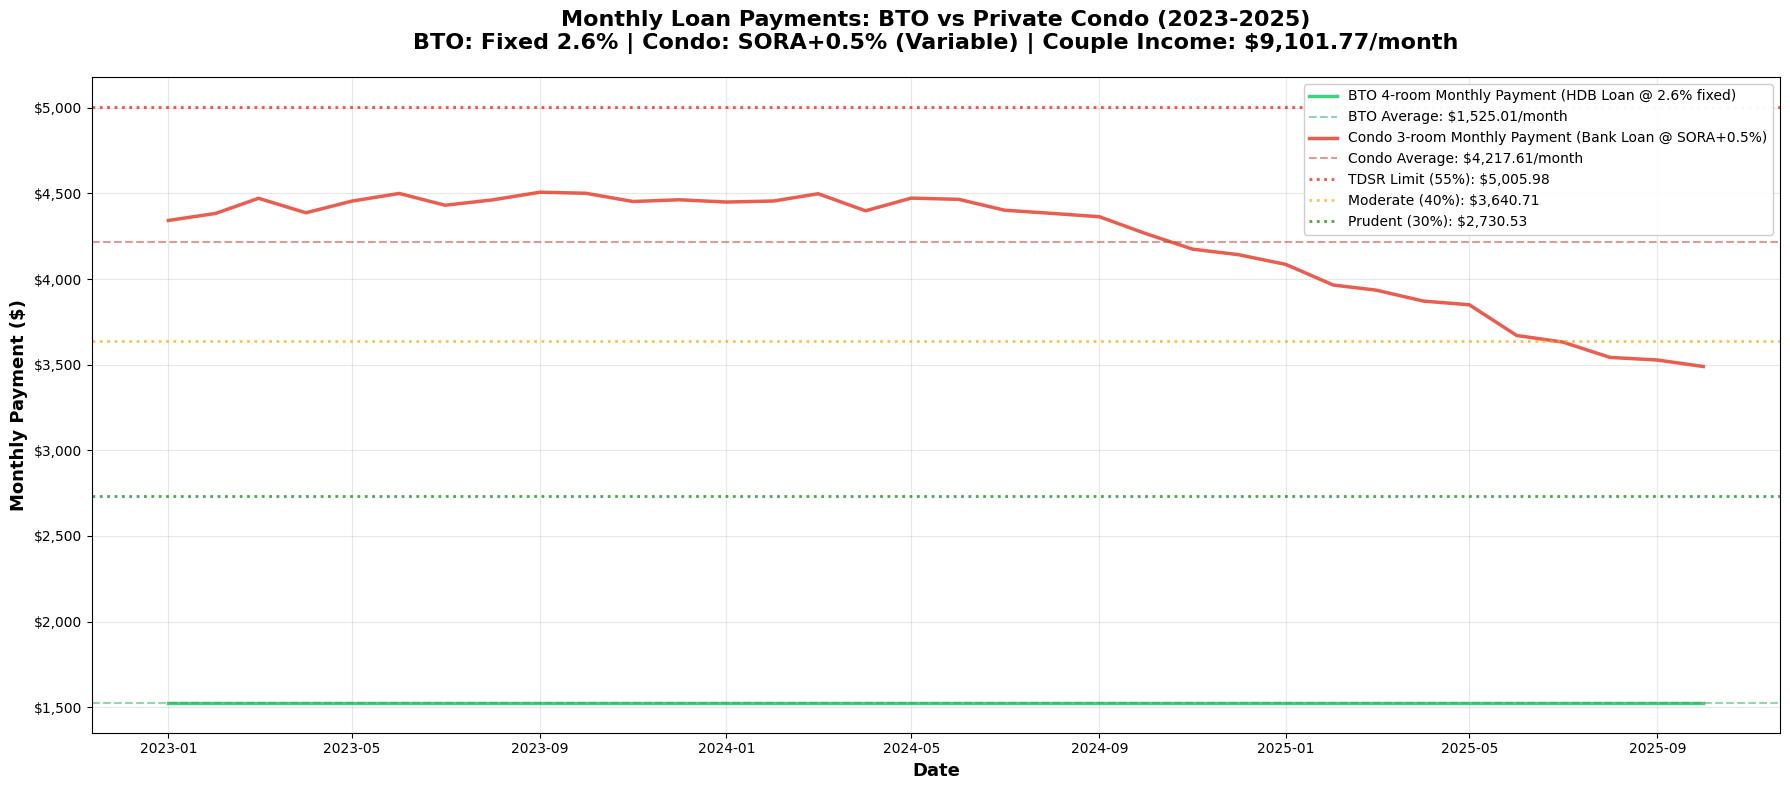


MONTHLY PAYMENT ANALYSIS (2023-2025)

BTO 4-room (HDB Loan @ 2.6% fixed):
  Average Monthly Payment: $1,525.01
  Min-Max Range: $1,525.01 - $1,525.01
  As % of Income: 16.8%
  Payment Stability: FIXED (no variation)

Condo 3-room (Bank Loan @ SORA+0.5%):
  Average Monthly Payment: $4,217.61
  Min-Max Range: $3,489.46 - $4,507.10
  As % of Income: 46.3%
  Payment Variation: $1,017.64 (due to SORA changes)

Monthly Payment Difference (Condo - BTO):
  Average: $2,692.60 more per month
  Percentage: 176.6% higher
  Annual Difference: $32,311.22

AFFORDABILITY THRESHOLDS:
  Prudent (30%): $2,730.53/month
  Moderate (40%): $3,640.71/month
  TDSR Limit (55%): $5,005.98/month


In [120]:
# ============================================================================
# VISUALIZE: MONTHLY PAYMENTS OVER TIME (Non-Cumulative)
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# Plot BTO monthly payments
if bto_burden_hdb is not None:
    ax.plot(bto_cumulative['date'], bto_cumulative['monthly_payment'], 
            label=f'BTO 4-room Monthly Payment (HDB Loan @ 2.6% fixed)', 
            color='#2ecc71', linewidth=2.5, alpha=0.9)
    
    # Show average monthly payment as horizontal line
    avg_bto_payment = bto_cumulative['monthly_payment'].mean()
    ax.axhline(y=avg_bto_payment, color='#27ae60', linestyle='--', linewidth=1.5, 
               label=f'BTO Average: ${avg_bto_payment:,.2f}/month', alpha=0.5)

# Plot Condo monthly payments
if condo_burden_to_plot is not None:
    ax.plot(condo_cumulative['date'], condo_cumulative['monthly_payment'], 
            label=f'Condo {condo_type_to_plot} Monthly Payment (Bank Loan @ SORA+0.5%)', 
            color='#e74c3c', linewidth=2.5, alpha=0.9)
    
    # Show average monthly payment as horizontal line
    avg_condo_payment = condo_cumulative['monthly_payment'].mean()
    ax.axhline(y=avg_condo_payment, color='#c0392b', linestyle='--', linewidth=1.5, 
               label=f'Condo Average: ${avg_condo_payment:,.2f}/month', alpha=0.5)

# Add TDSR and prudent thresholds for reference
monthly_income = DINK_2023
tdsr_threshold = monthly_income * 0.55
prudent_threshold = monthly_income * 0.30
moderate_threshold = monthly_income * 0.40

ax.axhline(y=tdsr_threshold, color='red', linestyle=':', linewidth=2, 
           label=f'TDSR Limit (55%): ${tdsr_threshold:,.2f}', alpha=0.7)
ax.axhline(y=moderate_threshold, color='orange', linestyle=':', linewidth=2, 
           label=f'Moderate (40%): ${moderate_threshold:,.2f}', alpha=0.7)
ax.axhline(y=prudent_threshold, color='green', linestyle=':', linewidth=2, 
           label=f'Prudent (30%): ${prudent_threshold:,.2f}', alpha=0.7)

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Monthly Payment ($)', fontsize=13, fontweight='bold')
ax.set_title('Monthly Loan Payments: BTO vs Private Condo (2023-2025)\n' +
             f'BTO: Fixed 2.6% | Condo: SORA+0.5% (Variable) | Couple Income: ${monthly_income:,.2f}/month',
             fontsize=16, fontweight='bold', pad=20)

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Legend
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print monthly payment statistics
print("\n" + "="*80)
print("MONTHLY PAYMENT ANALYSIS (2023-2025)")
print("="*80)

if bto_burden_hdb is not None:
    bto_monthly_avg = bto_cumulative['monthly_payment'].mean()
    bto_monthly_min = bto_cumulative['monthly_payment'].min()
    bto_monthly_max = bto_cumulative['monthly_payment'].max()
    
    print(f"\nBTO 4-room (HDB Loan @ 2.6% fixed):")
    print(f"  Average Monthly Payment: ${bto_monthly_avg:,.2f}")
    print(f"  Min-Max Range: ${bto_monthly_min:,.2f} - ${bto_monthly_max:,.2f}")
    print(f"  As % of Income: {(bto_monthly_avg/monthly_income)*100:.1f}%")
    print(f"  Payment Stability: FIXED (no variation)")

if condo_burden_to_plot is not None:
    condo_monthly_avg = condo_cumulative['monthly_payment'].mean()
    condo_monthly_min = condo_cumulative['monthly_payment'].min()
    condo_monthly_max = condo_cumulative['monthly_payment'].max()
    
    print(f"\nCondo {condo_type_to_plot} (Bank Loan @ SORA+0.5%):")
    print(f"  Average Monthly Payment: ${condo_monthly_avg:,.2f}")
    print(f"  Min-Max Range: ${condo_monthly_min:,.2f} - ${condo_monthly_max:,.2f}")
    print(f"  As % of Income: {(condo_monthly_avg/monthly_income)*100:.1f}%")
    print(f"  Payment Variation: ${condo_monthly_max - condo_monthly_min:,.2f} (due to SORA changes)")

if bto_burden_hdb is not None and condo_burden_to_plot is not None:
    difference = condo_monthly_avg - bto_monthly_avg
    print(f"\nMonthly Payment Difference (Condo - BTO):")
    print(f"  Average: ${difference:,.2f} more per month")
    print(f"  Percentage: {(difference/bto_monthly_avg)*100:.1f}% higher")
    print(f"  Annual Difference: ${difference * 12:,.2f}")

print("\n" + "="*80)
print("AFFORDABILITY THRESHOLDS:")
print(f"  Prudent (30%): ${prudent_threshold:,.2f}/month")
print(f"  Moderate (40%): ${moderate_threshold:,.2f}/month")
print(f"  TDSR Limit (55%): ${tdsr_threshold:,.2f}/month")
print("="*80)


# Conclusion

## Key Findings

### 1. Affordability Gap: BTO vs Private Condo
The analysis reveals a **significant affordability difference** between BTO flats and private condominiums in Punggol for a dual-income, no-kids (DINK) couple with average graduate salaries:

- **Condo monthly payments are substantially higher than HDB**, reaching **nearly triple** the BTO monthly payment
- This stark difference is driven by:
  - **Higher property prices** for condos
  - **Larger downpayment requirements** (25% vs 10%)
  - **Variable SORA-based interest rates** (averaging higher than HDB's 2.6% fixed rate)
  - **Higher stamp duties and renovation costs**

### 2. TDSR Compliance and Financial Health
The condo option **approaches the TDSR limit (55% of gross income)**, which poses serious financial risks:

- ⚠️ **Unhealthy debt burden**: Operating near the regulatory maximum leaves minimal financial buffer
- ⚠️ **Limited flexibility**: Little room for other financial goals (savings, investments, emergencies)
- ⚠️ **Income vulnerability**: Any income disruption (job loss, pay cut, career change) could lead to financial distress

**Recommendation**: Even couples with higher wages should perform detailed affordability calculations before committing to a private condo purchase. A comfortable financial position requires staying well below TDSR limits.

### 3. Interest Rate Volatility Risk
The analysis of **SORA rates (2023-2025)** demonstrates significant volatility in private property financing:

- ✅ **Potential benefit**: SORA rates can drop below HDB's fixed 2.6%, temporarily reducing monthly payments
- ❌ **Major risk**: Sharp interest rate spikes can cause sudden payment increases
- ❌ **Compounding effect**: When operating near TDSR limits, rate increases create severe financial strain
- ❌ **Unpredictability**: Difficult to budget long-term when payments fluctuate with market conditions

**Contrast with HDB loans**: The **fixed 2.6% rate** provides:
- Payment stability and predictability
- Protection from market volatility
- Easier long-term financial planning

### 4. Cumulative Financial Burden
Over the 3-year analysis period (2023-2025), the cumulative cost difference is substantial:

- **Upfront costs**: Condos require significantly higher initial capital (downpayment, stamp duty, renovation)
- **Ongoing payments**: Monthly loan payments accumulate to a much larger total for condos
- **Opportunity cost**: Money tied up in higher housing costs cannot be invested elsewhere

### 5. Informed Decision-Making is Critical
Couples must make **evidence-based decisions** when choosing housing options:

- 📊 **Consider total cost of ownership**, not just purchase price
- 📊 **Factor in interest rate scenarios**: best-case, average, and worst-case SORA movements
- 📊 **Assess risk tolerance**: ability to absorb payment increases during rate spikes
- 📊 **Evaluate lifestyle trade-offs**: condo amenities vs financial flexibility
- 📊 **Plan for life changes**: marriage, children, career transitions, economic downturns

**Bottom line**: While private condos offer lifestyle benefits, they come with substantially higher financial commitments and risks. BTO flats provide a more affordable and financially stable path to homeownership for average-earning graduate couples.

---

# Limitations

This analysis, while comprehensive, has several limitations that should be acknowledged:

## 1. Income Data Accuracy
- **GES (Graduate Employment Survey) income** may not accurately represent the typical DINK couple scenario
- Most graduates work for **several years before settling down**, leading to:
  - **Higher actual salaries** due to career progression and annual increments
  - However, the increase may be **moderate** (10-30% higher) rather than dramatic
- Industry and specialization variations not captured in aggregate GES data
- Does not account for bonuses, variable compensation, or dual career growth trajectories

## 2. Fixed Assumptions
- **Renovation costs** are estimates and vary widely based on:
  - Quality of finishes and materials
  - Extent of renovation work
  - Contractor pricing and market conditions
- **Loan tenure** fixed at 25 years; shorter/longer tenures affect affordability
- **LTV ratios** assumed at maximum; some buyers may opt for higher downpayments
- Does not consider CPF usage for housing (OA withdrawals, grants, accrued interest)

## 3. Lifestyle and Non-Financial Factors
- Analysis focuses on **financial metrics only**
- Does not quantify intangible benefits:
  - Condo facilities (pool, gym, security)
  - Location prestige and social status
  - Unit size and layout preferences
  - Freehold vs leasehold considerations
  - Investment and resale potential

## 4. Economic and Policy Context
- Analysis assumes **current regulatory framework**:
  - TDSR limits, loan tenures, CPF rules
  - HDB eligibility and BTO selection process
  - Stamp duty rates and structures
- Government policies may change, affecting affordability calculations
- Does not account for grants (e.g., CPF Housing Grant, Proximity Housing Grant)

## 5. Geographic and Market Segmentation
- Focused on **Punggol only**; different neighborhoods have different dynamics
- Private condo market is diverse: mass-market vs luxury segments have different price-to-income ratios
- BTO supply and demand vary by location and launch timing

Despite these limitations, the analysis provides a **robust foundation** for understanding the financial trade-offs between BTO and private condo purchases for graduate couples in Singapore.